# Проект 3. Решить задачу DaNetQA / BoolQ

Можно решить как задачу для русского, так и для английского.

Либо провести эксперименты с многоязычной моделью

https://russiansuperglue.com/ru/tasks/task_info/DaNetQA

## Описание
Причинно-следственная связь, логический вывод, Natural Language Inference

DaNetQA - это набор да/нет вопросов с ответами и фрагментом текста, содержащим ответ. Все вопросы были написаны авторами без каких-либо искусственных ограничений.

Каждый пример представляет собой триплет (вопрос, фрагмент текста, ответ) с заголовком страницы в качестве необязательного дополнительного контекста.

Настройка классификации текстовых пар аналогична существующим задачам логического вывода (NLI)

### Тип задачи
Логика, Commonsense, Знания о мире. Бинарная классификация: true/false

## Notebook prepeares

In [2]:
%pip install nltk
%pip install jinja2
%pip install gensim
%pip install sklearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.5 MB/s eta 0:00:00a 0:00:010m


In [1]:
import matplotlib.pyplot as plt
#from sklearn.metrics import accuracy_score
import os

base_path = os.path.abspath('')

try:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = os.path.join(base_path, 'drive/MyDrive/DSnML_Innopolis2022')
except:
    pass

print(f"Root path: '{base_path}'")

trainPartNameRaw = 'train_L0'
testPartNameRaw =  'test_L0'
validatePartNameRaw = 'val_L0'

trainPartNameL1 = 'train_L1'
testPartNameL1 = 'test_L1' 
validatePartNameL1 = 'val_L1'
data_path = os.path.join(base_path, 'DaNetQA')
print(f"Dataset path: {data_path}")

def fileNameData(s):
    return f"{os.path.join(data_path, s)}.jsonl"

Root path: '/home/leysh/git_repos/DSnML_Innopolis2022/00_Final_Attestation'
Dataset path: /home/leysh/git_repos/DSnML_Innopolis2022/00_Final_Attestation/DaNetQA


# Исследование данных

In [2]:
import unicodedata
import torch
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 0)

import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

nltk.download('stopwords')

/home/leysh/miniconda3/envs/catalyst1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/leysh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Utils/Class

In [6]:
def loadJSONL(path, name = ""):
    b_print_info = len(name) > 0
    stat = None
    
    df = pd.read_json(path, lines=True)
    if b_print_info:
        print(name)
        display(df.head())
        pd_data = []
        for col in df.columns.values[0:2]:
            lenSymb = [len(x) for x in df[col]]
            pd_data.append([f"{col}(symbols)", np.min(lenSymb), np.max(lenSymb), int(np.mean(lenSymb))])
            lenTok = [len(word_tokenize(x)) for x in df[col]]
            pd_data.append([f"{col}(words)", np.min(lenTok), np.max(lenTok), int(np.mean(lenTok))])
        stat = pd.DataFrame(pd_data, columns=['label', 'MIN', 'MAX', 'MEAN'])
        print("Stats:")
        display(stat)


    # Y    
    if (df.columns.values == 'label').any():
        s = np.unique(df['label'].to_numpy(), return_counts=True)[1]
        if b_print_info:
            print(f"True answer: {s[1]}")
            print(f"False answer: {s[0]}")
            print("")

            
    return df, stat

## Поэтапно обрабатываем данные


In [8]:
class DataCleaner:
    def __init__(self) -> None:
        self.flag_verbose = True

        self.stop_words = stopwords.words('russian')
        self.stemmer = SnowballStemmer('russian')

        self.count_removed_symbols = dict()
        self.count_removed_words = dict()

        self.count_replaced_symbols = dict()
        self.dict_replaced_symbols = dict()

        self.count_replaced_words = dict()
        self.dict_replaced_words = dict()

        self.char_to_remove = ['«', '»', '—', ',', '.', '-', '/', ':', '!', "?", "(", ")", "{", "}", "[", "]", "@", "#", "$", "%", "^", "&", "*", "=", "|", "\\", ">", "<"]
        self.char_to_replace = [['ё', 'е']]

    # функция подсчета количества измененных слов
    def addReplacedWord(self, s_from, s_to = ' '):
        if not self.count_replaced_words.keys().__contains__(s_from):
            self.count_replaced_words[s_from] = 0
        self.count_replaced_words[s_from] += 1
        self.dict_replaced_words[s_from] = s_to

    # функция подсчета количества удаленных слов
    def addRemovedWord(self, w):
        if w == ' ':
            if not self.count_removed_symbols.keys().__contains__(w):
                self.count_removed_symbols[w] = 0
            self.count_removed_symbols[w] += 1

    # функция подсчета количества удаленных символов
    def addReplacedSymbol(self, s_from, s_to = ' '):
        if s_to == ' ':
            if not self.count_removed_symbols.keys().__contains__(s_from):
                self.count_removed_symbols[s_from] = 0
            self.count_removed_symbols[s_from] += 1
        else:
            if not self.count_replaced_symbols.keys().__contains__(s_from):
                self.count_replaced_symbols[s_from] = 0
            self.count_replaced_symbols[s_from] += 1
            self.dict_replaced_symbols[s_from] = s_to

    # удаление знаков ударения и прочих символов unicode
    def unicodeToAscii(self, s):
        tmp = []
        for c in unicodedata.normalize('NFD', s):
            if unicodedata.category(c) != 'Mn':
                tmp.append(c)
            else:
                self.addReplacedSymbol(c)
        return ''.join(tmp)

    # если нужно удалить, то заменяем на пробел чтоб не потерят разделения слов
    def replaceChar(self, s):
        tmp = []
        for i, c in enumerate(s):
            if self.char_to_remove.__contains__(c):
                self.addReplacedSymbol(c, s[i])
                tmp.append(' ')
            else:
                tmp.append(c)
        s = "".join(tmp)

        for s_from, s_to in self.char_to_replace:
            if c == s_from:
                s[i] = s_to
                self.addReplacedSymbol(s_from, s_to)
        return s

    # удаляем лишние пробелы
    def trimSpaces(self, s):
        while s.__contains__('  '):
            s = s.replace('  ', ' ')
        s = s.strip()
        return s

    # удаляем слва из stopwords
    def removeStopWords(self, s):
        tmp = []
        for word in word_tokenize(s):
            if word not in self.stop_words:
                tmp.append(word)
            else:
                self.addRemovedWord(word)
        return " ".join(tmp)

    # удаляем слва из stopwords
    def StemmWords(self, s):
        tmp = []
        for word in word_tokenize(s):
            wordStemmed = self.stemmer.stem(word)
            tmp.append(wordStemmed)
            if word != wordStemmed:
                self.addReplacedWord(word, wordStemmed)
        return " ".join(tmp)

    # основная функция для процессинга
    def clean(self, df, column, level):
        for i in range(len(df)):
            # L1 удаляем только юникод
            if level > 0:
                df[column][i] = self.unicodeToAscii(df[column][i])
            # L2 переводим в нижний регистр
            if level > 1:
                df[column][i] = df[column][i].lower()
            # L3 удаляем символы пунктуации и тд
            if level > 2:
                df[column][i] = self.replaceChar(df[column][i])
            # L4 удаляем стоп слова
            #if level > 3:
            #    df[column][i] = self.removeStopWords(df[column][i])
            # L5 леммитизация
            if level > 4:
                df[column][i] = self.StemmWords(df[column][i])
            
            # удаляем пробелы
            df[column][i] = self.trimSpaces(df[column][i])
        return df

    # прокси для выключения вывода на экран summary
    def print(self, vals):
        if self.flag_verbose == True:
            print(vals)

    # прокси для выключения вывода на экран summary
    def display(self, vals):
            if self.flag_verbose == True:
                display(vals)

    # сбор лога в dataframe, опциональный вывод на экран 
    def summary(self, verbose = True):
        self.flag_verbose = verbose
        dfs = dict()

        if len(self.count_removed_symbols) > 0:
            cols = ["symbol", "count_removed"]
            dfRemoved = pd.DataFrame(columns=cols)
            self.print("===================================")
            self.print("===        Removed Chars        ===")
            self.print("===================================")
            for c in self.count_removed_symbols:
                current_df = pd.DataFrame([[c, self.count_removed_symbols[c]]], columns=cols) 
                dfRemoved = pd.concat([dfRemoved, current_df], ignore_index=True)
            self.display(dfRemoved)
            dfs['Removed Chars'] = dfRemoved

                
        if len(self.count_removed_words) > 0:
            cols = ["word", "count_removed"]
            dfRemoved = pd.DataFrame(columns=cols)
            self.print("===================================")
            self.print("===        Removed Words        ===")
            self.print("===================================")
            for c in self.count_removed_words:
                current_df = pd.DataFrame([[c, self.count_removed_words[c]]], columns=cols) 
                dfRemoved = pd.concat([dfRemoved, current_df], ignore_index=True)
            self.display(dfRemoved)
            dfs['Removed Words'] = dfRemoved

                
        if len(self.dict_replaced_symbols) > 0:
            cols = ["symbol_from", "symbol_to", "count_replaced"]
            dfRemoved = pd.DataFrame(columns=cols)
            self.print("===================================")
            self.print("===        Replaced Chars       ===")
            self.print("===================================")
            for c in self.dict_replaced_symbols:
                current_df = pd.DataFrame([[ c, self.dict_replaced_symbols[c], self.count_replaced_symbols[c]]], columns=cols) 
                dfRemoved = pd.concat([dfRemoved, current_df], ignore_index=True)
            self.display(dfRemoved)
            dfs['Replaced Chars'] = dfRemoved

                
        if len(self.dict_replaced_words) > 0:
            cols = ["word_from", "word_to", "count_replaced"]
            dfRemoved = pd.DataFrame(columns=cols)
            self.print("===================================")
            self.print("===        Stemmed Words        ===")
            self.print("===================================")
            for c in self.dict_replaced_words:
                current_df = pd.DataFrame([[ c, self.dict_replaced_words[c], self.count_replaced_words[c]]], columns=cols) 
                dfRemoved = pd.concat([dfRemoved, current_df], ignore_index=True)
            self.display(dfRemoved)
            dfs['Stemmed Words'] = dfRemoved

        return dfs

In [11]:
df_train, _ = loadJSONL(fileNameData(trainPartNameRaw))
df_validation, _ = loadJSONL(fileNameData(validatePartNameRaw))
df_test, _ = loadJSONL(fileNameData(testPartNameRaw))

cleanLog = dict()
for iL in [3, 5]: #range(1, 6):
    cleaner = DataCleaner()

    df_train = cleaner.clean(df_train, 'passage', iL)
    df_test = cleaner.clean(df_test, 'passage', iL)
    df_validation = cleaner.clean(df_validation, 'passage', iL)
    df_train = cleaner.clean(df_train, 'question', iL)
    df_test = cleaner.clean(df_test, 'question', iL)
    df_validation = cleaner.clean(df_validation, 'question', iL)

    cleanLog[iL] = cleaner.summary(False)
    df_train.to_json(fileNameData(f"train_L{iL}"), lines=True, orient='records')
    df_test.to_json(fileNameData(f"test_L{iL}"), lines=True, orient='records')
    df_validation.to_json(fileNameData(f"val_L{iL}"), lines=True, orient='records')

/tmp/ipykernel_368/4292193179.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = self.unicodeToAscii(df[column][i])
/tmp/ipykernel_368/4292193179.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = df[column][i].lower()
/tmp/ipykernel_368/4292193179.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = self.replaceChar(df[column][i])
/tmp/ipykernel_368/4292193179.py:120: SettingWithC

In [74]:
# сохраняем таблицы с изменениями в файл для последующей визуализации
torch.save(cleanLog,"cleanLog.pt")

## Примеры данных

### L0: исходные данные

In [25]:
df_trainL0, df_trainL0_stat = loadJSONL(fileNameData("train_L0"), "Train set")
df_validationL0, df_validationL0_stat = loadJSONL(fileNameData("train_L0"), "Validation set")
df_testL0, df_testL0_stat = loadJSONL(fileNameData("train_L0"), "Test set:")

Train set


,question,passage,label,idx
0,Вднх - это выставочный центр?,«Вы́ставочный центр» — станция Московского монорельса. Расположена между станциями «Улица Академика Королёва» и «Улица Сергея Эйзенштейна». Находится на территории Останкинского района Северо-Восточного административного округа города Москвы. Переход на станцию ВДНХ Калужско-Рижской линии. Названа в честь Всероссийского выставочного центра — названия ВДНХ с 1992 по 2014 год. 20 ноября 2004 года линия монорельса начала работать в «экскурсионном режиме» и перевезла первых пассажиров .,True,0
1,Вднх - это выставочный центр?,"Вы́ставка достиже́ний наро́дного хозя́йства , в 1959—1991 годах — Вы́ставка достиже́ний наро́дного хозя́йства СССР , в 1992—2014 годах — Всеросси́йский вы́ставочный центр ) — выставочный комплекс в Останкинском районе Северо-Восточного административного округа города Москвы, второй по величине выставочный комплекс в городе. Входит в 50 крупнейших выставочных центров мира. Ежегодно ВДНХ посещают 30 млн гостей. 1 августа 2019 года выставка отпраздновала 80-летний юбилей. Территориально ВДНХ объединена с парком «Останкино» и Главным ботаническим садом , их общая площадь составляет почти 700 га: 240,2 га — площадь ВДНХ, 75,6 га — площадь парка «Останкино», 361 га — площадь ГБС, 9,5 га музейно-выставочный центр «Рабочий и колхозница» и площадь перед аркой Главного входа. На территории Выставки расположено множество шедевров архитектуры — 49 объектов ВДНХ признаны памятниками культурного наследия.",True,1
2,Был ли джиган в black star?,"Вместе с этим треком они выступили на церемонии вручения наград MTV RMA — это был первый выход Джигана на большую сцену. В 2007 году Джиган стал официальным артистом лейбла Black Star Inc., выпустил первый песню и клип «Одноклассница» — совместная работа с Тимати. В марте 2011 года появилась совместная с Юлей Савичевой композиция «Отпусти». Песня поднялась в радиочарте «Tophit» до 8 места и заняла первое место чарта Weekly Audience Choice Top Hit . Количество просмотров клипа на YouTube превысило 17 миллионов.",True,2
3,Xiaomi конкурент apple?,"Xiaomi — китайская компания, основанная в 2010 году и занимающаяся выпуском электроники и бытовой техники, а также разработкой программного обеспечения. Основной продукцией компании являются смартфоны, первый из которых был выпущен в 2011 году. В настоящее время Xiaomi производит широкий ассортимент смартфонов в разных ценовых сегментах и является одним из крупнейших производителей смартфонов в мире. Так, в третьем квартале 2014 года эта компания заняла наивысшее для себя третье место в мире по поставкам смартфонов, набрав 5,2 % в штучном выражении и уступив лишь Samsung и Apple . За весь 2017 год компания заняла по продажам первое место в Китае и второе место в Индии. В данном списке приводятся все смартфоны, когда-либо выпущенные компанией Xiaomi.",True,3
4,Был ли автомат калашникова в вов?,"Отметив некоторые недостатки и в целом удачную конструкцию, специалисты ГАУ не рекомендовали принимать ПП Калашникова на вооружение по технологическим причинам. Заключение гласило: С 1942 года Калашников работал на Центральном научно-исследовательском полигоне стрелкового и миномётного вооружения ГАУ РККА. Здесь в 1944 году он создал опытный образец самозарядного карабина, который, хотя и не вышел в серийное производство, частично послужил прототипом для создания автомата. С 1945 года Михаил Калашников начал разработку автоматического оружия под промежуточный патрон 7,62×39 образца 1943 года. Автомат Калашникова победил в конкурсе 1947 года и был принят на вооружение.",False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),14,182,41
1,question(words),3,30,7
2,passage(symbols),294,3200,723
3,passage(words),48,587,115


True answer: 1061
False answer: 688

Validation set


,question,passage,label,idx
0,Вднх - это выставочный центр?,«Вы́ставочный центр» — станция Московского монорельса. Расположена между станциями «Улица Академика Королёва» и «Улица Сергея Эйзенштейна». Находится на территории Останкинского района Северо-Восточного административного округа города Москвы. Переход на станцию ВДНХ Калужско-Рижской линии. Названа в честь Всероссийского выставочного центра — названия ВДНХ с 1992 по 2014 год. 20 ноября 2004 года линия монорельса начала работать в «экскурсионном режиме» и перевезла первых пассажиров .,True,0
1,Вднх - это выставочный центр?,"Вы́ставка достиже́ний наро́дного хозя́йства , в 1959—1991 годах — Вы́ставка достиже́ний наро́дного хозя́йства СССР , в 1992—2014 годах — Всеросси́йский вы́ставочный центр ) — выставочный комплекс в Останкинском районе Северо-Восточного административного округа города Москвы, второй по величине выставочный комплекс в городе. Входит в 50 крупнейших выставочных центров мира. Ежегодно ВДНХ посещают 30 млн гостей. 1 августа 2019 года выставка отпраздновала 80-летний юбилей. Территориально ВДНХ объединена с парком «Останкино» и Главным ботаническим садом , их общая площадь составляет почти 700 га: 240,2 га — площадь ВДНХ, 75,6 га — площадь парка «Останкино», 361 га — площадь ГБС, 9,5 га музейно-выставочный центр «Рабочий и колхозница» и площадь перед аркой Главного входа. На территории Выставки расположено множество шедевров архитектуры — 49 объектов ВДНХ признаны памятниками культурного наследия.",True,1
2,Был ли джиган в black star?,"Вместе с этим треком они выступили на церемонии вручения наград MTV RMA — это был первый выход Джигана на большую сцену. В 2007 году Джиган стал официальным артистом лейбла Black Star Inc., выпустил первый песню и клип «Одноклассница» — совместная работа с Тимати. В марте 2011 года появилась совместная с Юлей Савичевой композиция «Отпусти». Песня поднялась в радиочарте «Tophit» до 8 места и заняла первое место чарта Weekly Audience Choice Top Hit . Количество просмотров клипа на YouTube превысило 17 миллионов.",True,2
3,Xiaomi конкурент apple?,"Xiaomi — китайская компания, основанная в 2010 году и занимающаяся выпуском электроники и бытовой техники, а также разработкой программного обеспечения. Основной продукцией компании являются смартфоны, первый из которых был выпущен в 2011 году. В настоящее время Xiaomi производит широкий ассортимент смартфонов в разных ценовых сегментах и является одним из крупнейших производителей смартфонов в мире. Так, в третьем квартале 2014 года эта компания заняла наивысшее для себя третье место в мире по поставкам смартфонов, набрав 5,2 % в штучном выражении и уступив лишь Samsung и Apple . За весь 2017 год компания заняла по продажам первое место в Китае и второе место в Индии. В данном списке приводятся все смартфоны, когда-либо выпущенные компанией Xiaomi.",True,3
4,Был ли автомат калашникова в вов?,"Отметив некоторые недостатки и в целом удачную конструкцию, специалисты ГАУ не рекомендовали принимать ПП Калашникова на вооружение по технологическим причинам. Заключение гласило: С 1942 года Калашников работал на Центральном научно-исследовательском полигоне стрелкового и миномётного вооружения ГАУ РККА. Здесь в 1944 году он создал опытный образец самозарядного карабина, который, хотя и не вышел в серийное производство, частично послужил прототипом для создания автомата. С 1945 года Михаил Калашников начал разработку автоматического оружия под промежуточный патрон 7,62×39 образца 1943 года. Автомат Калашникова победил в конкурсе 1947 года и был принят на вооружение.",False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),14,182,41
1,question(words),3,30,7
2,passage(symbols),294,3200,723
3,passage(words),48,587,115


True answer: 1061
False answer: 688

Test set:


,question,passage,label,idx
0,Вднх - это выставочный центр?,«Вы́ставочный центр» — станция Московского монорельса. Расположена между станциями «Улица Академика Королёва» и «Улица Сергея Эйзенштейна». Находится на территории Останкинского района Северо-Восточного административного округа города Москвы. Переход на станцию ВДНХ Калужско-Рижской линии. Названа в честь Всероссийского выставочного центра — названия ВДНХ с 1992 по 2014 год. 20 ноября 2004 года линия монорельса начала работать в «экскурсионном режиме» и перевезла первых пассажиров .,True,0
1,Вднх - это выставочный центр?,"Вы́ставка достиже́ний наро́дного хозя́йства , в 1959—1991 годах — Вы́ставка достиже́ний наро́дного хозя́йства СССР , в 1992—2014 годах — Всеросси́йский вы́ставочный центр ) — выставочный комплекс в Останкинском районе Северо-Восточного административного округа города Москвы, второй по величине выставочный комплекс в городе. Входит в 50 крупнейших выставочных центров мира. Ежегодно ВДНХ посещают 30 млн гостей. 1 августа 2019 года выставка отпраздновала 80-летний юбилей. Территориально ВДНХ объединена с парком «Останкино» и Главным ботаническим садом , их общая площадь составляет почти 700 га: 240,2 га — площадь ВДНХ, 75,6 га — площадь парка «Останкино», 361 га — площадь ГБС, 9,5 га музейно-выставочный центр «Рабочий и колхозница» и площадь перед аркой Главного входа. На территории Выставки расположено множество шедевров архитектуры — 49 объектов ВДНХ признаны памятниками культурного наследия.",True,1
2,Был ли джиган в black star?,"Вместе с этим треком они выступили на церемонии вручения наград MTV RMA — это был первый выход Джигана на большую сцену. В 2007 году Джиган стал официальным артистом лейбла Black Star Inc., выпустил первый песню и клип «Одноклассница» — совместная работа с Тимати. В марте 2011 года появилась совместная с Юлей Савичевой композиция «Отпусти». Песня поднялась в радиочарте «Tophit» до 8 места и заняла первое место чарта Weekly Audience Choice Top Hit . Количество просмотров клипа на YouTube превысило 17 миллионов.",True,2
3,Xiaomi конкурент apple?,"Xiaomi — китайская компания, основанная в 2010 году и занимающаяся выпуском электроники и бытовой техники, а также разработкой программного обеспечения. Основной продукцией компании являются смартфоны, первый из которых был выпущен в 2011 году. В настоящее время Xiaomi производит широкий ассортимент смартфонов в разных ценовых сегментах и является одним из крупнейших производителей смартфонов в мире. Так, в третьем квартале 2014 года эта компания заняла наивысшее для себя третье место в мире по поставкам смартфонов, набрав 5,2 % в штучном выражении и уступив лишь Samsung и Apple . За весь 2017 год компания заняла по продажам первое место в Китае и второе место в Индии. В данном списке приводятся все смартфоны, когда-либо выпущенные компанией Xiaomi.",True,3
4,Был ли автомат калашникова в вов?,"Отметив некоторые недостатки и в целом удачную конструкцию, специалисты ГАУ не рекомендовали принимать ПП Калашникова на вооружение по технологическим причинам. Заключение гласило: С 1942 года Калашников работал на Центральном научно-исследовательском полигоне стрелкового и миномётного вооружения ГАУ РККА. Здесь в 1944 году он создал опытный образец самозарядного карабина, который, хотя и не вышел в серийное производство, частично послужил прототипом для создания автомата. С 1945 года Михаил Калашников начал разработку автоматического оружия под промежуточный патрон 7,62×39 образца 1943 года. Автомат Калашникова победил в конкурсе 1947 года и был принят на вооружение.",False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),14,182,41
1,question(words),3,30,7
2,passage(symbols),294,3200,723
3,passage(words),48,587,115


True answer: 1061
False answer: 688



### L1: удаляем только юникод

In [5]:
df_trainL1, df_trainL1_stat = loadJSONL(fileNameData("train_L1"), "Train set")
df_validationL1, df_validationL1_stat  = loadJSONL(fileNameData("train_L1"), "Validation set")
df_testL1, df_testL1_stat = loadJSONL(fileNameData("train_L1"), "Test set:")

Train set


,question,passage,label,idx
0,Вднх - это выставочныи центр?,«Выставочныи центр» — станция Московского монорельса. Расположена между станциями «Улица Академика Королева» и «Улица Сергея Эизенштеина». Находится на территории Останкинского раиона Северо-Восточного административного округа города Москвы. Переход на станцию ВДНХ Калужско-Рижскои линии. Названа в честь Всероссииского выставочного центра — названия ВДНХ с 1992 по 2014 год. 20 ноября 2004 года линия монорельса начала работать в «экскурсионном режиме» и перевезла первых пассажиров .,True,0
1,Вднх - это выставочныи центр?,"Выставка достижении народного хозяиства , в 1959—1991 годах — Выставка достижении народного хозяиства СССР , в 1992—2014 годах — Всероссиискии выставочныи центр ) — выставочныи комплекс в Останкинском раионе Северо-Восточного административного округа города Москвы, второи по величине выставочныи комплекс в городе. Входит в 50 крупнеиших выставочных центров мира. Ежегодно ВДНХ посещают 30 млн гостеи. 1 августа 2019 года выставка отпраздновала 80-летнии юбилеи. Территориально ВДНХ объединена с парком «Останкино» и Главным ботаническим садом , их общая площадь составляет почти 700 га: 240,2 га — площадь ВДНХ, 75,6 га — площадь парка «Останкино», 361 га — площадь ГБС, 9,5 га музеино-выставочныи центр «Рабочии и колхозница» и площадь перед аркои Главного входа. На территории Выставки расположено множество шедевров архитектуры — 49 объектов ВДНХ признаны памятниками культурного наследия.",True,1
2,Был ли джиган в black star?,"Вместе с этим треком они выступили на церемонии вручения наград MTV RMA — это был первыи выход Джигана на большую сцену. В 2007 году Джиган стал официальным артистом леибла Black Star Inc., выпустил первыи песню и клип «Одноклассница» — совместная работа с Тимати. В марте 2011 года появилась совместная с Юлеи Савичевои композиция «Отпусти». Песня поднялась в радиочарте «Tophit» до 8 места и заняла первое место чарта Weekly Audience Choice Top Hit . Количество просмотров клипа на YouTube превысило 17 миллионов.",True,2
3,Xiaomi конкурент apple?,"Xiaomi — китаиская компания, основанная в 2010 году и занимающаяся выпуском электроники и бытовои техники, а также разработкои программного обеспечения. Основнои продукциеи компании являются смартфоны, первыи из которых был выпущен в 2011 году. В настоящее время Xiaomi производит широкии ассортимент смартфонов в разных ценовых сегментах и является одним из крупнеиших производителеи смартфонов в мире. Так, в третьем квартале 2014 года эта компания заняла наивысшее для себя третье место в мире по поставкам смартфонов, набрав 5,2 % в штучном выражении и уступив лишь Samsung и Apple . За весь 2017 год компания заняла по продажам первое место в Китае и второе место в Индии. В данном списке приводятся все смартфоны, когда-либо выпущенные компаниеи Xiaomi.",True,3
4,Был ли автомат калашникова в вов?,"Отметив некоторые недостатки и в целом удачную конструкцию, специалисты ГАУ не рекомендовали принимать ПП Калашникова на вооружение по технологическим причинам. Заключение гласило: С 1942 года Калашников работал на Центральном научно-исследовательском полигоне стрелкового и минометного вооружения ГАУ РККА. Здесь в 1944 году он создал опытныи образец самозарядного карабина, которыи, хотя и не вышел в серииное производство, частично послужил прототипом для создания автомата. С 1945 года Михаил Калашников начал разработку автоматического оружия под промежуточныи патрон 7,62×39 образца 1943 года. Автомат Калашникова победил в конкурсе 1947 года и был принят на вооружение.",False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),14,182,41
1,question(words),3,30,7
2,passage(symbols),293,3200,722
3,passage(words),48,587,115


True answer: 1061
False answer: 688

Validation set


,question,passage,label,idx
0,Вднх - это выставочныи центр?,«Выставочныи центр» — станция Московского монорельса. Расположена между станциями «Улица Академика Королева» и «Улица Сергея Эизенштеина». Находится на территории Останкинского раиона Северо-Восточного административного округа города Москвы. Переход на станцию ВДНХ Калужско-Рижскои линии. Названа в честь Всероссииского выставочного центра — названия ВДНХ с 1992 по 2014 год. 20 ноября 2004 года линия монорельса начала работать в «экскурсионном режиме» и перевезла первых пассажиров .,True,0
1,Вднх - это выставочныи центр?,"Выставка достижении народного хозяиства , в 1959—1991 годах — Выставка достижении народного хозяиства СССР , в 1992—2014 годах — Всероссиискии выставочныи центр ) — выставочныи комплекс в Останкинском раионе Северо-Восточного административного округа города Москвы, второи по величине выставочныи комплекс в городе. Входит в 50 крупнеиших выставочных центров мира. Ежегодно ВДНХ посещают 30 млн гостеи. 1 августа 2019 года выставка отпраздновала 80-летнии юбилеи. Территориально ВДНХ объединена с парком «Останкино» и Главным ботаническим садом , их общая площадь составляет почти 700 га: 240,2 га — площадь ВДНХ, 75,6 га — площадь парка «Останкино», 361 га — площадь ГБС, 9,5 га музеино-выставочныи центр «Рабочии и колхозница» и площадь перед аркои Главного входа. На территории Выставки расположено множество шедевров архитектуры — 49 объектов ВДНХ признаны памятниками культурного наследия.",True,1
2,Был ли джиган в black star?,"Вместе с этим треком они выступили на церемонии вручения наград MTV RMA — это был первыи выход Джигана на большую сцену. В 2007 году Джиган стал официальным артистом леибла Black Star Inc., выпустил первыи песню и клип «Одноклассница» — совместная работа с Тимати. В марте 2011 года появилась совместная с Юлеи Савичевои композиция «Отпусти». Песня поднялась в радиочарте «Tophit» до 8 места и заняла первое место чарта Weekly Audience Choice Top Hit . Количество просмотров клипа на YouTube превысило 17 миллионов.",True,2
3,Xiaomi конкурент apple?,"Xiaomi — китаиская компания, основанная в 2010 году и занимающаяся выпуском электроники и бытовои техники, а также разработкои программного обеспечения. Основнои продукциеи компании являются смартфоны, первыи из которых был выпущен в 2011 году. В настоящее время Xiaomi производит широкии ассортимент смартфонов в разных ценовых сегментах и является одним из крупнеиших производителеи смартфонов в мире. Так, в третьем квартале 2014 года эта компания заняла наивысшее для себя третье место в мире по поставкам смартфонов, набрав 5,2 % в штучном выражении и уступив лишь Samsung и Apple . За весь 2017 год компания заняла по продажам первое место в Китае и второе место в Индии. В данном списке приводятся все смартфоны, когда-либо выпущенные компаниеи Xiaomi.",True,3
4,Был ли автомат калашникова в вов?,"Отметив некоторые недостатки и в целом удачную конструкцию, специалисты ГАУ не рекомендовали принимать ПП Калашникова на вооружение по технологическим причинам. Заключение гласило: С 1942 года Калашников работал на Центральном научно-исследовательском полигоне стрелкового и минометного вооружения ГАУ РККА. Здесь в 1944 году он создал опытныи образец самозарядного карабина, которыи, хотя и не вышел в серииное производство, частично послужил прототипом для создания автомата. С 1945 года Михаил Калашников начал разработку автоматического оружия под промежуточныи патрон 7,62×39 образца 1943 года. Автомат Калашникова победил в конкурсе 1947 года и был принят на вооружение.",False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),14,182,41
1,question(words),3,30,7
2,passage(symbols),293,3200,722
3,passage(words),48,587,115


True answer: 1061
False answer: 688

Test set:


,question,passage,label,idx
0,Вднх - это выставочныи центр?,«Выставочныи центр» — станция Московского монорельса. Расположена между станциями «Улица Академика Королева» и «Улица Сергея Эизенштеина». Находится на территории Останкинского раиона Северо-Восточного административного округа города Москвы. Переход на станцию ВДНХ Калужско-Рижскои линии. Названа в честь Всероссииского выставочного центра — названия ВДНХ с 1992 по 2014 год. 20 ноября 2004 года линия монорельса начала работать в «экскурсионном режиме» и перевезла первых пассажиров .,True,0
1,Вднх - это выставочныи центр?,"Выставка достижении народного хозяиства , в 1959—1991 годах — Выставка достижении народного хозяиства СССР , в 1992—2014 годах — Всероссиискии выставочныи центр ) — выставочныи комплекс в Останкинском раионе Северо-Восточного административного округа города Москвы, второи по величине выставочныи комплекс в городе. Входит в 50 крупнеиших выставочных центров мира. Ежегодно ВДНХ посещают 30 млн гостеи. 1 августа 2019 года выставка отпраздновала 80-летнии юбилеи. Территориально ВДНХ объединена с парком «Останкино» и Главным ботаническим садом , их общая площадь составляет почти 700 га: 240,2 га — площадь ВДНХ, 75,6 га — площадь парка «Останкино», 361 га — площадь ГБС, 9,5 га музеино-выставочныи центр «Рабочии и колхозница» и площадь перед аркои Главного входа. На территории Выставки расположено множество шедевров архитектуры — 49 объектов ВДНХ признаны памятниками культурного наследия.",True,1
2,Был ли джиган в black star?,"Вместе с этим треком они выступили на церемонии вручения наград MTV RMA — это был первыи выход Джигана на большую сцену. В 2007 году Джиган стал официальным артистом леибла Black Star Inc., выпустил первыи песню и клип «Одноклассница» — совместная работа с Тимати. В марте 2011 года появилась совместная с Юлеи Савичевои композиция «Отпусти». Песня поднялась в радиочарте «Tophit» до 8 места и заняла первое место чарта Weekly Audience Choice Top Hit . Количество просмотров клипа на YouTube превысило 17 миллионов.",True,2
3,Xiaomi конкурент apple?,"Xiaomi — китаиская компания, основанная в 2010 году и занимающаяся выпуском электроники и бытовои техники, а также разработкои программного обеспечения. Основнои продукциеи компании являются смартфоны, первыи из которых был выпущен в 2011 году. В настоящее время Xiaomi производит широкии ассортимент смартфонов в разных ценовых сегментах и является одним из крупнеиших производителеи смартфонов в мире. Так, в третьем квартале 2014 года эта компания заняла наивысшее для себя третье место в мире по поставкам смартфонов, набрав 5,2 % в штучном выражении и уступив лишь Samsung и Apple . За весь 2017 год компания заняла по продажам первое место в Китае и второе место в Индии. В данном списке приводятся все смартфоны, когда-либо выпущенные компаниеи Xiaomi.",True,3
4,Был ли автомат калашникова в вов?,"Отметив некоторые недостатки и в целом удачную конструкцию, специалисты ГАУ не рекомендовали принимать ПП Калашникова на вооружение по технологическим причинам. Заключение гласило: С 1942 года Калашников работал на Центральном научно-исследовательском полигоне стрелкового и минометного вооружения ГАУ РККА. Здесь в 1944 году он создал опытныи образец самозарядного карабина, которыи, хотя и не вышел в серииное производство, частично послужил прототипом для создания автомата. С 1945 года Михаил Калашников начал разработку автоматического оружия под промежуточныи патрон 7,62×39 образца 1943 года. Автомат Калашникова победил в конкурсе 1947 года и был принят на вооружение.",False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),14,182,41
1,question(words),3,30,7
2,passage(symbols),293,3200,722
3,passage(words),48,587,115


True answer: 1061
False answer: 688



### L2: переводим в нижний регистр

In [6]:
df_trainL2, df_trainL2_stat = loadJSONL(fileNameData("train_L2"), "Train set")
df_validationL2, df_validationL2_stat = loadJSONL(fileNameData("train_L2"), "Validation set")
df_testL2, df_testL2_stat = loadJSONL(fileNameData("train_L2"), "Test set:")

Train set


,question,passage,label,idx
0,вднх - это выставочныи центр?,«выставочныи центр» — станция московского монорельса. расположена между станциями «улица академика королева» и «улица сергея эизенштеина». находится на территории останкинского раиона северо-восточного административного округа города москвы. переход на станцию вднх калужско-рижскои линии. названа в честь всероссииского выставочного центра — названия вднх с 1992 по 2014 год. 20 ноября 2004 года линия монорельса начала работать в «экскурсионном режиме» и перевезла первых пассажиров .,True,0
1,вднх - это выставочныи центр?,"выставка достижении народного хозяиства , в 1959—1991 годах — выставка достижении народного хозяиства ссср , в 1992—2014 годах — всероссиискии выставочныи центр ) — выставочныи комплекс в останкинском раионе северо-восточного административного округа города москвы, второи по величине выставочныи комплекс в городе. входит в 50 крупнеиших выставочных центров мира. ежегодно вднх посещают 30 млн гостеи. 1 августа 2019 года выставка отпраздновала 80-летнии юбилеи. территориально вднх объединена с парком «останкино» и главным ботаническим садом , их общая площадь составляет почти 700 га: 240,2 га — площадь вднх, 75,6 га — площадь парка «останкино», 361 га — площадь гбс, 9,5 га музеино-выставочныи центр «рабочии и колхозница» и площадь перед аркои главного входа. на территории выставки расположено множество шедевров архитектуры — 49 объектов вднх признаны памятниками культурного наследия.",True,1
2,был ли джиган в black star?,"вместе с этим треком они выступили на церемонии вручения наград mtv rma — это был первыи выход джигана на большую сцену. в 2007 году джиган стал официальным артистом леибла black star inc., выпустил первыи песню и клип «одноклассница» — совместная работа с тимати. в марте 2011 года появилась совместная с юлеи савичевои композиция «отпусти». песня поднялась в радиочарте «tophit» до 8 места и заняла первое место чарта weekly audience choice top hit . количество просмотров клипа на youtube превысило 17 миллионов.",True,2
3,xiaomi конкурент apple?,"xiaomi — китаиская компания, основанная в 2010 году и занимающаяся выпуском электроники и бытовои техники, а также разработкои программного обеспечения. основнои продукциеи компании являются смартфоны, первыи из которых был выпущен в 2011 году. в настоящее время xiaomi производит широкии ассортимент смартфонов в разных ценовых сегментах и является одним из крупнеиших производителеи смартфонов в мире. так, в третьем квартале 2014 года эта компания заняла наивысшее для себя третье место в мире по поставкам смартфонов, набрав 5,2 % в штучном выражении и уступив лишь samsung и apple . за весь 2017 год компания заняла по продажам первое место в китае и второе место в индии. в данном списке приводятся все смартфоны, когда-либо выпущенные компаниеи xiaomi.",True,3
4,был ли автомат калашникова в вов?,"отметив некоторые недостатки и в целом удачную конструкцию, специалисты гау не рекомендовали принимать пп калашникова на вооружение по технологическим причинам. заключение гласило: с 1942 года калашников работал на центральном научно-исследовательском полигоне стрелкового и минометного вооружения гау ркка. здесь в 1944 году он создал опытныи образец самозарядного карабина, которыи, хотя и не вышел в серииное производство, частично послужил прототипом для создания автомата. с 1945 года михаил калашников начал разработку автоматического оружия под промежуточныи патрон 7,62×39 образца 1943 года. автомат калашникова победил в конкурсе 1947 года и был принят на вооружение.",False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),14,182,41
1,question(words),3,30,7
2,passage(symbols),293,3200,722
3,passage(words),48,587,115


True answer: 1061
False answer: 688

Validation set


,question,passage,label,idx
0,вднх - это выставочныи центр?,«выставочныи центр» — станция московского монорельса. расположена между станциями «улица академика королева» и «улица сергея эизенштеина». находится на территории останкинского раиона северо-восточного административного округа города москвы. переход на станцию вднх калужско-рижскои линии. названа в честь всероссииского выставочного центра — названия вднх с 1992 по 2014 год. 20 ноября 2004 года линия монорельса начала работать в «экскурсионном режиме» и перевезла первых пассажиров .,True,0
1,вднх - это выставочныи центр?,"выставка достижении народного хозяиства , в 1959—1991 годах — выставка достижении народного хозяиства ссср , в 1992—2014 годах — всероссиискии выставочныи центр ) — выставочныи комплекс в останкинском раионе северо-восточного административного округа города москвы, второи по величине выставочныи комплекс в городе. входит в 50 крупнеиших выставочных центров мира. ежегодно вднх посещают 30 млн гостеи. 1 августа 2019 года выставка отпраздновала 80-летнии юбилеи. территориально вднх объединена с парком «останкино» и главным ботаническим садом , их общая площадь составляет почти 700 га: 240,2 га — площадь вднх, 75,6 га — площадь парка «останкино», 361 га — площадь гбс, 9,5 га музеино-выставочныи центр «рабочии и колхозница» и площадь перед аркои главного входа. на территории выставки расположено множество шедевров архитектуры — 49 объектов вднх признаны памятниками культурного наследия.",True,1
2,был ли джиган в black star?,"вместе с этим треком они выступили на церемонии вручения наград mtv rma — это был первыи выход джигана на большую сцену. в 2007 году джиган стал официальным артистом леибла black star inc., выпустил первыи песню и клип «одноклассница» — совместная работа с тимати. в марте 2011 года появилась совместная с юлеи савичевои композиция «отпусти». песня поднялась в радиочарте «tophit» до 8 места и заняла первое место чарта weekly audience choice top hit . количество просмотров клипа на youtube превысило 17 миллионов.",True,2
3,xiaomi конкурент apple?,"xiaomi — китаиская компания, основанная в 2010 году и занимающаяся выпуском электроники и бытовои техники, а также разработкои программного обеспечения. основнои продукциеи компании являются смартфоны, первыи из которых был выпущен в 2011 году. в настоящее время xiaomi производит широкии ассортимент смартфонов в разных ценовых сегментах и является одним из крупнеиших производителеи смартфонов в мире. так, в третьем квартале 2014 года эта компания заняла наивысшее для себя третье место в мире по поставкам смартфонов, набрав 5,2 % в штучном выражении и уступив лишь samsung и apple . за весь 2017 год компания заняла по продажам первое место в китае и второе место в индии. в данном списке приводятся все смартфоны, когда-либо выпущенные компаниеи xiaomi.",True,3
4,был ли автомат калашникова в вов?,"отметив некоторые недостатки и в целом удачную конструкцию, специалисты гау не рекомендовали принимать пп калашникова на вооружение по технологическим причинам. заключение гласило: с 1942 года калашников работал на центральном научно-исследовательском полигоне стрелкового и минометного вооружения гау ркка. здесь в 1944 году он создал опытныи образец самозарядного карабина, которыи, хотя и не вышел в серииное производство, частично послужил прототипом для создания автомата. с 1945 года михаил калашников начал разработку автоматического оружия под промежуточныи патрон 7,62×39 образца 1943 года. автомат калашникова победил в конкурсе 1947 года и был принят на вооружение.",False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),14,182,41
1,question(words),3,30,7
2,passage(symbols),293,3200,722
3,passage(words),48,587,115


True answer: 1061
False answer: 688

Test set:


,question,passage,label,idx
0,вднх - это выставочныи центр?,«выставочныи центр» — станция московского монорельса. расположена между станциями «улица академика королева» и «улица сергея эизенштеина». находится на территории останкинского раиона северо-восточного административного округа города москвы. переход на станцию вднх калужско-рижскои линии. названа в честь всероссииского выставочного центра — названия вднх с 1992 по 2014 год. 20 ноября 2004 года линия монорельса начала работать в «экскурсионном режиме» и перевезла первых пассажиров .,True,0
1,вднх - это выставочныи центр?,"выставка достижении народного хозяиства , в 1959—1991 годах — выставка достижении народного хозяиства ссср , в 1992—2014 годах — всероссиискии выставочныи центр ) — выставочныи комплекс в останкинском раионе северо-восточного административного округа города москвы, второи по величине выставочныи комплекс в городе. входит в 50 крупнеиших выставочных центров мира. ежегодно вднх посещают 30 млн гостеи. 1 августа 2019 года выставка отпраздновала 80-летнии юбилеи. территориально вднх объединена с парком «останкино» и главным ботаническим садом , их общая площадь составляет почти 700 га: 240,2 га — площадь вднх, 75,6 га — площадь парка «останкино», 361 га — площадь гбс, 9,5 га музеино-выставочныи центр «рабочии и колхозница» и площадь перед аркои главного входа. на территории выставки расположено множество шедевров архитектуры — 49 объектов вднх признаны памятниками культурного наследия.",True,1
2,был ли джиган в black star?,"вместе с этим треком они выступили на церемонии вручения наград mtv rma — это был первыи выход джигана на большую сцену. в 2007 году джиган стал официальным артистом леибла black star inc., выпустил первыи песню и клип «одноклассница» — совместная работа с тимати. в марте 2011 года появилась совместная с юлеи савичевои композиция «отпусти». песня поднялась в радиочарте «tophit» до 8 места и заняла первое место чарта weekly audience choice top hit . количество просмотров клипа на youtube превысило 17 миллионов.",True,2
3,xiaomi конкурент apple?,"xiaomi — китаиская компания, основанная в 2010 году и занимающаяся выпуском электроники и бытовои техники, а также разработкои программного обеспечения. основнои продукциеи компании являются смартфоны, первыи из которых был выпущен в 2011 году. в настоящее время xiaomi производит широкии ассортимент смартфонов в разных ценовых сегментах и является одним из крупнеиших производителеи смартфонов в мире. так, в третьем квартале 2014 года эта компания заняла наивысшее для себя третье место в мире по поставкам смартфонов, набрав 5,2 % в штучном выражении и уступив лишь samsung и apple . за весь 2017 год компания заняла по продажам первое место в китае и второе место в индии. в данном списке приводятся все смартфоны, когда-либо выпущенные компаниеи xiaomi.",True,3
4,был ли автомат калашникова в вов?,"отметив некоторые недостатки и в целом удачную конструкцию, специалисты гау не рекомендовали принимать пп калашникова на вооружение по технологическим причинам. заключение гласило: с 1942 года калашников работал на центральном научно-исследовательском полигоне стрелкового и минометного вооружения гау ркка. здесь в 1944 году он создал опытныи образец самозарядного карабина, которыи, хотя и не вышел в серииное производство, частично послужил прототипом для создания автомата. с 1945 года михаил калашников начал разработку автоматического оружия под промежуточныи патрон 7,62×39 образца 1943 года. автомат калашникова победил в конкурсе 1947 года и был принят на вооружение.",False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),14,182,41
1,question(words),3,30,7
2,passage(symbols),293,3200,722
3,passage(words),48,587,115


True answer: 1061
False answer: 688



### L3: удаляем символы пунктуации и тд

In [7]:
df_trainL3, df_trainL3_stat = loadJSONL(fileNameData("train_L3"), "Train set")
df_validationL3, df_validationL3_stat = loadJSONL(fileNameData("train_L3"), "Validation set")
df_testL3, df_testL3_stat = loadJSONL(fileNameData("train_L3"), "Test set:")

Train set


,question,passage,label,idx
0,вднх это выставочныи центр,выставочныи центр станция московского монорельса расположена между станциями улица академика королева и улица сергея эизенштеина находится на территории останкинского раиона северо восточного административного округа города москвы переход на станцию вднх калужско рижскои линии названа в честь всероссииского выставочного центра названия вднх с 1992 по 2014 год 20 ноября 2004 года линия монорельса начала работать в экскурсионном режиме и перевезла первых пассажиров,True,0
1,вднх это выставочныи центр,выставка достижении народного хозяиства в 1959 1991 годах выставка достижении народного хозяиства ссср в 1992 2014 годах всероссиискии выставочныи центр выставочныи комплекс в останкинском раионе северо восточного административного округа города москвы второи по величине выставочныи комплекс в городе входит в 50 крупнеиших выставочных центров мира ежегодно вднх посещают 30 млн гостеи 1 августа 2019 года выставка отпраздновала 80 летнии юбилеи территориально вднх объединена с парком останкино и главным ботаническим садом их общая площадь составляет почти 700 га 240 2 га площадь вднх 75 6 га площадь парка останкино 361 га площадь гбс 9 5 га музеино выставочныи центр рабочии и колхозница и площадь перед аркои главного входа на территории выставки расположено множество шедевров архитектуры 49 объектов вднх признаны памятниками культурного наследия,True,1
2,был ли джиган в black star,вместе с этим треком они выступили на церемонии вручения наград mtv rma это был первыи выход джигана на большую сцену в 2007 году джиган стал официальным артистом леибла black star inc выпустил первыи песню и клип одноклассница совместная работа с тимати в марте 2011 года появилась совместная с юлеи савичевои композиция отпусти песня поднялась в радиочарте tophit до 8 места и заняла первое место чарта weekly audience choice top hit количество просмотров клипа на youtube превысило 17 миллионов,True,2
3,xiaomi конкурент apple,xiaomi китаиская компания основанная в 2010 году и занимающаяся выпуском электроники и бытовои техники а также разработкои программного обеспечения основнои продукциеи компании являются смартфоны первыи из которых был выпущен в 2011 году в настоящее время xiaomi производит широкии ассортимент смартфонов в разных ценовых сегментах и является одним из крупнеиших производителеи смартфонов в мире так в третьем квартале 2014 года эта компания заняла наивысшее для себя третье место в мире по поставкам смартфонов набрав 5 2 в штучном выражении и уступив лишь samsung и apple за весь 2017 год компания заняла по продажам первое место в китае и второе место в индии в данном списке приводятся все смартфоны когда либо выпущенные компаниеи xiaomi,True,3
4,был ли автомат калашникова в вов,отметив некоторые недостатки и в целом удачную конструкцию специалисты гау не рекомендовали принимать пп калашникова на вооружение по технологическим причинам заключение гласило с 1942 года калашников работал на центральном научно исследовательском полигоне стрелкового и минометного вооружения гау ркка здесь в 1944 году он создал опытныи образец самозарядного карабина которыи хотя и не вышел в серииное производство частично послужил прототипом для создания автомата с 1945 года михаил калашников начал разработку автоматического оружия под промежуточныи патрон 7 62×39 образца 1943 года автомат калашникова победил в конкурсе 1947 года и был принят на вооружение,False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),13,179,40
1,question(words),2,28,6
2,passage(symbols),271,3095,701
3,passage(words),40,479,98


True answer: 1061
False answer: 688

Validation set


,question,passage,label,idx
0,вднх это выставочныи центр,выставочныи центр станция московского монорельса расположена между станциями улица академика королева и улица сергея эизенштеина находится на территории останкинского раиона северо восточного административного округа города москвы переход на станцию вднх калужско рижскои линии названа в честь всероссииского выставочного центра названия вднх с 1992 по 2014 год 20 ноября 2004 года линия монорельса начала работать в экскурсионном режиме и перевезла первых пассажиров,True,0
1,вднх это выставочныи центр,выставка достижении народного хозяиства в 1959 1991 годах выставка достижении народного хозяиства ссср в 1992 2014 годах всероссиискии выставочныи центр выставочныи комплекс в останкинском раионе северо восточного административного округа города москвы второи по величине выставочныи комплекс в городе входит в 50 крупнеиших выставочных центров мира ежегодно вднх посещают 30 млн гостеи 1 августа 2019 года выставка отпраздновала 80 летнии юбилеи территориально вднх объединена с парком останкино и главным ботаническим садом их общая площадь составляет почти 700 га 240 2 га площадь вднх 75 6 га площадь парка останкино 361 га площадь гбс 9 5 га музеино выставочныи центр рабочии и колхозница и площадь перед аркои главного входа на территории выставки расположено множество шедевров архитектуры 49 объектов вднх признаны памятниками культурного наследия,True,1
2,был ли джиган в black star,вместе с этим треком они выступили на церемонии вручения наград mtv rma это был первыи выход джигана на большую сцену в 2007 году джиган стал официальным артистом леибла black star inc выпустил первыи песню и клип одноклассница совместная работа с тимати в марте 2011 года появилась совместная с юлеи савичевои композиция отпусти песня поднялась в радиочарте tophit до 8 места и заняла первое место чарта weekly audience choice top hit количество просмотров клипа на youtube превысило 17 миллионов,True,2
3,xiaomi конкурент apple,xiaomi китаиская компания основанная в 2010 году и занимающаяся выпуском электроники и бытовои техники а также разработкои программного обеспечения основнои продукциеи компании являются смартфоны первыи из которых был выпущен в 2011 году в настоящее время xiaomi производит широкии ассортимент смартфонов в разных ценовых сегментах и является одним из крупнеиших производителеи смартфонов в мире так в третьем квартале 2014 года эта компания заняла наивысшее для себя третье место в мире по поставкам смартфонов набрав 5 2 в штучном выражении и уступив лишь samsung и apple за весь 2017 год компания заняла по продажам первое место в китае и второе место в индии в данном списке приводятся все смартфоны когда либо выпущенные компаниеи xiaomi,True,3
4,был ли автомат калашникова в вов,отметив некоторые недостатки и в целом удачную конструкцию специалисты гау не рекомендовали принимать пп калашникова на вооружение по технологическим причинам заключение гласило с 1942 года калашников работал на центральном научно исследовательском полигоне стрелкового и минометного вооружения гау ркка здесь в 1944 году он создал опытныи образец самозарядного карабина которыи хотя и не вышел в серииное производство частично послужил прототипом для создания автомата с 1945 года михаил калашников начал разработку автоматического оружия под промежуточныи патрон 7 62×39 образца 1943 года автомат калашникова победил в конкурсе 1947 года и был принят на вооружение,False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),13,179,40
1,question(words),2,28,6
2,passage(symbols),271,3095,701
3,passage(words),40,479,98


True answer: 1061
False answer: 688

Test set:


,question,passage,label,idx
0,вднх это выставочныи центр,выставочныи центр станция московского монорельса расположена между станциями улица академика королева и улица сергея эизенштеина находится на территории останкинского раиона северо восточного административного округа города москвы переход на станцию вднх калужско рижскои линии названа в честь всероссииского выставочного центра названия вднх с 1992 по 2014 год 20 ноября 2004 года линия монорельса начала работать в экскурсионном режиме и перевезла первых пассажиров,True,0
1,вднх это выставочныи центр,выставка достижении народного хозяиства в 1959 1991 годах выставка достижении народного хозяиства ссср в 1992 2014 годах всероссиискии выставочныи центр выставочныи комплекс в останкинском раионе северо восточного административного округа города москвы второи по величине выставочныи комплекс в городе входит в 50 крупнеиших выставочных центров мира ежегодно вднх посещают 30 млн гостеи 1 августа 2019 года выставка отпраздновала 80 летнии юбилеи территориально вднх объединена с парком останкино и главным ботаническим садом их общая площадь составляет почти 700 га 240 2 га площадь вднх 75 6 га площадь парка останкино 361 га площадь гбс 9 5 га музеино выставочныи центр рабочии и колхозница и площадь перед аркои главного входа на территории выставки расположено множество шедевров архитектуры 49 объектов вднх признаны памятниками культурного наследия,True,1
2,был ли джиган в black star,вместе с этим треком они выступили на церемонии вручения наград mtv rma это был первыи выход джигана на большую сцену в 2007 году джиган стал официальным артистом леибла black star inc выпустил первыи песню и клип одноклассница совместная работа с тимати в марте 2011 года появилась совместная с юлеи савичевои композиция отпусти песня поднялась в радиочарте tophit до 8 места и заняла первое место чарта weekly audience choice top hit количество просмотров клипа на youtube превысило 17 миллионов,True,2
3,xiaomi конкурент apple,xiaomi китаиская компания основанная в 2010 году и занимающаяся выпуском электроники и бытовои техники а также разработкои программного обеспечения основнои продукциеи компании являются смартфоны первыи из которых был выпущен в 2011 году в настоящее время xiaomi производит широкии ассортимент смартфонов в разных ценовых сегментах и является одним из крупнеиших производителеи смартфонов в мире так в третьем квартале 2014 года эта компания заняла наивысшее для себя третье место в мире по поставкам смартфонов набрав 5 2 в штучном выражении и уступив лишь samsung и apple за весь 2017 год компания заняла по продажам первое место в китае и второе место в индии в данном списке приводятся все смартфоны когда либо выпущенные компаниеи xiaomi,True,3
4,был ли автомат калашникова в вов,отметив некоторые недостатки и в целом удачную конструкцию специалисты гау не рекомендовали принимать пп калашникова на вооружение по технологическим причинам заключение гласило с 1942 года калашников работал на центральном научно исследовательском полигоне стрелкового и минометного вооружения гау ркка здесь в 1944 году он создал опытныи образец самозарядного карабина которыи хотя и не вышел в серииное производство частично послужил прототипом для создания автомата с 1945 года михаил калашников начал разработку автоматического оружия под промежуточныи патрон 7 62×39 образца 1943 года автомат калашникова победил в конкурсе 1947 года и был принят на вооружение,False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),13,179,40
1,question(words),2,28,6
2,passage(symbols),271,3095,701
3,passage(words),40,479,98


True answer: 1061
False answer: 688



### L4: удаляем стоп слова

In [8]:
df_trainL4, df_trainL4_stat = loadJSONL(fileNameData("train_L4"), "Train set")
df_validationL4, df_validationL4_stat = loadJSONL(fileNameData("train_L4"), "Validation set")
df_testL4, df_testL4_stat  = loadJSONL(fileNameData("train_L4"), "Test set:")

Train set


,question,passage,label,idx
0,вднх это выставочныи центр,выставочныи центр станция московского монорельса расположена станциями улица академика королева улица сергея эизенштеина находится территории останкинского раиона северо восточного административного округа города москвы переход станцию вднх калужско рижскои линии названа честь всероссииского выставочного центра названия вднх 1992 2014 год 20 ноября 2004 года линия монорельса начала работать экскурсионном режиме перевезла первых пассажиров,True,0
1,вднх это выставочныи центр,выставка достижении народного хозяиства 1959 1991 годах выставка достижении народного хозяиства ссср 1992 2014 годах всероссиискии выставочныи центр выставочныи комплекс останкинском раионе северо восточного административного округа города москвы второи величине выставочныи комплекс городе входит 50 крупнеиших выставочных центров мира ежегодно вднх посещают 30 млн гостеи 1 августа 2019 года выставка отпраздновала 80 летнии юбилеи территориально вднх объединена парком останкино главным ботаническим садом общая площадь составляет 700 га 240 2 га площадь вднх 75 6 га площадь парка останкино 361 га площадь гбс 9 5 га музеино выставочныи центр рабочии колхозница площадь аркои главного входа территории выставки расположено множество шедевров архитектуры 49 объектов вднх признаны памятниками культурного наследия,True,1
2,джиган black star,вместе этим треком выступили церемонии вручения наград mtv rma это первыи выход джигана большую сцену 2007 году джиган стал официальным артистом леибла black star inc выпустил первыи песню клип одноклассница совместная работа тимати марте 2011 года появилась совместная юлеи савичевои композиция отпусти песня поднялась радиочарте tophit 8 места заняла первое место чарта weekly audience choice top hit количество просмотров клипа youtube превысило 17 миллионов,True,2
3,xiaomi конкурент apple,xiaomi китаиская компания основанная 2010 году занимающаяся выпуском электроники бытовои техники также разработкои программного обеспечения основнои продукциеи компании являются смартфоны первыи которых выпущен 2011 году настоящее время xiaomi производит широкии ассортимент смартфонов разных ценовых сегментах является одним крупнеиших производителеи смартфонов мире третьем квартале 2014 года эта компания заняла наивысшее третье место мире поставкам смартфонов набрав 5 2 штучном выражении уступив лишь samsung apple весь 2017 год компания заняла продажам первое место китае второе место индии данном списке приводятся смартфоны либо выпущенные компаниеи xiaomi,True,3
4,автомат калашникова вов,отметив некоторые недостатки целом удачную конструкцию специалисты гау рекомендовали принимать пп калашникова вооружение технологическим причинам заключение гласило 1942 года калашников работал центральном научно исследовательском полигоне стрелкового минометного вооружения гау ркка 1944 году создал опытныи образец самозарядного карабина которыи хотя вышел серииное производство частично послужил прототипом создания автомата 1945 года михаил калашников начал разработку автоматического оружия промежуточныи патрон 7 62×39 образца 1943 года автомат калашникова победил конкурсе 1947 года принят вооружение,False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),4,162,32
1,question(words),1,21,4
2,passage(symbols),245,2656,625
3,passage(words),33,340,74


True answer: 1061
False answer: 688

Validation set


,question,passage,label,idx
0,вднх это выставочныи центр,выставочныи центр станция московского монорельса расположена станциями улица академика королева улица сергея эизенштеина находится территории останкинского раиона северо восточного административного округа города москвы переход станцию вднх калужско рижскои линии названа честь всероссииского выставочного центра названия вднх 1992 2014 год 20 ноября 2004 года линия монорельса начала работать экскурсионном режиме перевезла первых пассажиров,True,0
1,вднх это выставочныи центр,выставка достижении народного хозяиства 1959 1991 годах выставка достижении народного хозяиства ссср 1992 2014 годах всероссиискии выставочныи центр выставочныи комплекс останкинском раионе северо восточного административного округа города москвы второи величине выставочныи комплекс городе входит 50 крупнеиших выставочных центров мира ежегодно вднх посещают 30 млн гостеи 1 августа 2019 года выставка отпраздновала 80 летнии юбилеи территориально вднх объединена парком останкино главным ботаническим садом общая площадь составляет 700 га 240 2 га площадь вднх 75 6 га площадь парка останкино 361 га площадь гбс 9 5 га музеино выставочныи центр рабочии колхозница площадь аркои главного входа территории выставки расположено множество шедевров архитектуры 49 объектов вднх признаны памятниками культурного наследия,True,1
2,джиган black star,вместе этим треком выступили церемонии вручения наград mtv rma это первыи выход джигана большую сцену 2007 году джиган стал официальным артистом леибла black star inc выпустил первыи песню клип одноклассница совместная работа тимати марте 2011 года появилась совместная юлеи савичевои композиция отпусти песня поднялась радиочарте tophit 8 места заняла первое место чарта weekly audience choice top hit количество просмотров клипа youtube превысило 17 миллионов,True,2
3,xiaomi конкурент apple,xiaomi китаиская компания основанная 2010 году занимающаяся выпуском электроники бытовои техники также разработкои программного обеспечения основнои продукциеи компании являются смартфоны первыи которых выпущен 2011 году настоящее время xiaomi производит широкии ассортимент смартфонов разных ценовых сегментах является одним крупнеиших производителеи смартфонов мире третьем квартале 2014 года эта компания заняла наивысшее третье место мире поставкам смартфонов набрав 5 2 штучном выражении уступив лишь samsung apple весь 2017 год компания заняла продажам первое место китае второе место индии данном списке приводятся смартфоны либо выпущенные компаниеи xiaomi,True,3
4,автомат калашникова вов,отметив некоторые недостатки целом удачную конструкцию специалисты гау рекомендовали принимать пп калашникова вооружение технологическим причинам заключение гласило 1942 года калашников работал центральном научно исследовательском полигоне стрелкового минометного вооружения гау ркка 1944 году создал опытныи образец самозарядного карабина которыи хотя вышел серииное производство частично послужил прототипом создания автомата 1945 года михаил калашников начал разработку автоматического оружия промежуточныи патрон 7 62×39 образца 1943 года автомат калашникова победил конкурсе 1947 года принят вооружение,False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),4,162,32
1,question(words),1,21,4
2,passage(symbols),245,2656,625
3,passage(words),33,340,74


True answer: 1061
False answer: 688

Test set:


,question,passage,label,idx
0,вднх это выставочныи центр,выставочныи центр станция московского монорельса расположена станциями улица академика королева улица сергея эизенштеина находится территории останкинского раиона северо восточного административного округа города москвы переход станцию вднх калужско рижскои линии названа честь всероссииского выставочного центра названия вднх 1992 2014 год 20 ноября 2004 года линия монорельса начала работать экскурсионном режиме перевезла первых пассажиров,True,0
1,вднх это выставочныи центр,выставка достижении народного хозяиства 1959 1991 годах выставка достижении народного хозяиства ссср 1992 2014 годах всероссиискии выставочныи центр выставочныи комплекс останкинском раионе северо восточного административного округа города москвы второи величине выставочныи комплекс городе входит 50 крупнеиших выставочных центров мира ежегодно вднх посещают 30 млн гостеи 1 августа 2019 года выставка отпраздновала 80 летнии юбилеи территориально вднх объединена парком останкино главным ботаническим садом общая площадь составляет 700 га 240 2 га площадь вднх 75 6 га площадь парка останкино 361 га площадь гбс 9 5 га музеино выставочныи центр рабочии колхозница площадь аркои главного входа территории выставки расположено множество шедевров архитектуры 49 объектов вднх признаны памятниками культурного наследия,True,1
2,джиган black star,вместе этим треком выступили церемонии вручения наград mtv rma это первыи выход джигана большую сцену 2007 году джиган стал официальным артистом леибла black star inc выпустил первыи песню клип одноклассница совместная работа тимати марте 2011 года появилась совместная юлеи савичевои композиция отпусти песня поднялась радиочарте tophit 8 места заняла первое место чарта weekly audience choice top hit количество просмотров клипа youtube превысило 17 миллионов,True,2
3,xiaomi конкурент apple,xiaomi китаиская компания основанная 2010 году занимающаяся выпуском электроники бытовои техники также разработкои программного обеспечения основнои продукциеи компании являются смартфоны первыи которых выпущен 2011 году настоящее время xiaomi производит широкии ассортимент смартфонов разных ценовых сегментах является одним крупнеиших производителеи смартфонов мире третьем квартале 2014 года эта компания заняла наивысшее третье место мире поставкам смартфонов набрав 5 2 штучном выражении уступив лишь samsung apple весь 2017 год компания заняла продажам первое место китае второе место индии данном списке приводятся смартфоны либо выпущенные компаниеи xiaomi,True,3
4,автомат калашникова вов,отметив некоторые недостатки целом удачную конструкцию специалисты гау рекомендовали принимать пп калашникова вооружение технологическим причинам заключение гласило 1942 года калашников работал центральном научно исследовательском полигоне стрелкового минометного вооружения гау ркка 1944 году создал опытныи образец самозарядного карабина которыи хотя вышел серииное производство частично послужил прототипом создания автомата 1945 года михаил калашников начал разработку автоматического оружия промежуточныи патрон 7 62×39 образца 1943 года автомат калашникова победил конкурсе 1947 года принят вооружение,False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),4,162,32
1,question(words),1,21,4
2,passage(symbols),245,2656,625
3,passage(words),33,340,74


True answer: 1061
False answer: 688



### L5: леммитизация

In [12]:
df_trainL5, df_trainL5_stat = loadJSONL(fileNameData("train_L5"), "Train set")
df_validationL5, df_validationL5_stat = loadJSONL(fileNameData("train_L5"), "Validation set")
df_testL5, df_testL5_stat = loadJSONL(fileNameData("train_L5"), "Test set:")

Train set


,question,passage,label,idx
0,вднх эт выставочны центр,выставочны центр станц московск монорельс располож межд станц улиц академик королев и улиц серге эизенштеин наход на территор останкинск раион север восточн административн округ город москв переход на станц вднх калужск рижско лин назва в чест всероссииск выставочн центр назван вднх с 1992 по 2014 год 20 ноябр 2004 год лин монорельс нача работа в экскурсион режим и перевезл перв пассажир,True,0
1,вднх эт выставочны центр,выставк достижен народн хозяиств в 1959 1991 год выставк достижен народн хозяиств ссср в 1992 2014 год всероссииск выставочны центр выставочны комплекс в останкинск раион север восточн административн округ город москв второ по величин выставочны комплекс в город вход в 50 крупнеиш выставочн центр мир ежегодн вднх посеща 30 млн гост 1 август 2019 год выставк отпразднова 80 летн юбил территориальн вднх объедин с парк останкин и главн ботаническ сад их общ площад составля почт 700 га 240 2 га площад вднх 75 6 га площад парк останкин 361 га площад гбс 9 5 га музеин выставочны центр рабоч и колхозниц и площад перед арко главн вход на территор выставк располож множеств шедевр архитектур 49 объект вднх призна памятник культурн наслед,True,1
2,был ли джига в black star,вмест с эт трек он выступ на церемон вручен наград mtv rma эт был первы выход джига на больш сцен в 2007 год джига стал официальн артист леибл black star inc выпуст первы песн и клип одноклассниц совместн работ с тимат в март 2011 год появ совместн с юл савичево композиц отпуст песн подня в радиочарт tophit до 8 мест и заня перв мест чарт weekly audience choice top hit количеств просмотр клип на youtube превыс 17 миллион,True,2
3,xiaomi конкурент apple,xiaomi китаиск компан основа в 2010 год и занима выпуск электроник и бытово техник а такж разработко программн обеспечен основно продукц компан явля смартфон первы из котор был выпущ в 2011 год в настоя врем xiaomi производ широк ассортимент смартфон в разн ценов сегмент и явля одн из крупнеиш производител смартфон в мир так в трет квартал 2014 год эт компан заня наивысш для себ трет мест в мир по поставк смартфон набра 5 2 в штучн выражен и уступ лиш samsung и apple за ве 2017 год компан заня по продаж перв мест в кита и втор мест в инд в дан списк привод все смартфон когд либ выпущен компан xiaomi,True,3
4,был ли автомат калашников в вов,отмет некотор недостатк и в цел удачн конструкц специалист га не рекомендова принима пп калашников на вооружен по технологическ причин заключен глас с 1942 год калашник работа на центральн научн исследовательск полигон стрелков и минометн вооружен га ркка зде в 1944 год он созда опытны образец самозарядн карабин которы хот и не вышел в сериин производств частичн послуж прототип для создан автомат с 1945 год миха калашник нача разработк автоматическ оруж под промежуточны патрон 7 62×39 образц 1943 год автомат калашников побед в конкурс 1947 год и был прин на вооружен,False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),10,151,34
1,question(words),2,28,6
2,passage(symbols),237,2508,584
3,passage(words),40,479,98


True answer: 1061
False answer: 688

Validation set


,question,passage,label,idx
0,вднх эт выставочны центр,выставочны центр станц московск монорельс располож межд станц улиц академик королев и улиц серге эизенштеин наход на территор останкинск раион север восточн административн округ город москв переход на станц вднх калужск рижско лин назва в чест всероссииск выставочн центр назван вднх с 1992 по 2014 год 20 ноябр 2004 год лин монорельс нача работа в экскурсион режим и перевезл перв пассажир,True,0
1,вднх эт выставочны центр,выставк достижен народн хозяиств в 1959 1991 год выставк достижен народн хозяиств ссср в 1992 2014 год всероссииск выставочны центр выставочны комплекс в останкинск раион север восточн административн округ город москв второ по величин выставочны комплекс в город вход в 50 крупнеиш выставочн центр мир ежегодн вднх посеща 30 млн гост 1 август 2019 год выставк отпразднова 80 летн юбил территориальн вднх объедин с парк останкин и главн ботаническ сад их общ площад составля почт 700 га 240 2 га площад вднх 75 6 га площад парк останкин 361 га площад гбс 9 5 га музеин выставочны центр рабоч и колхозниц и площад перед арко главн вход на территор выставк располож множеств шедевр архитектур 49 объект вднх призна памятник культурн наслед,True,1
2,был ли джига в black star,вмест с эт трек он выступ на церемон вручен наград mtv rma эт был первы выход джига на больш сцен в 2007 год джига стал официальн артист леибл black star inc выпуст первы песн и клип одноклассниц совместн работ с тимат в март 2011 год появ совместн с юл савичево композиц отпуст песн подня в радиочарт tophit до 8 мест и заня перв мест чарт weekly audience choice top hit количеств просмотр клип на youtube превыс 17 миллион,True,2
3,xiaomi конкурент apple,xiaomi китаиск компан основа в 2010 год и занима выпуск электроник и бытово техник а такж разработко программн обеспечен основно продукц компан явля смартфон первы из котор был выпущ в 2011 год в настоя врем xiaomi производ широк ассортимент смартфон в разн ценов сегмент и явля одн из крупнеиш производител смартфон в мир так в трет квартал 2014 год эт компан заня наивысш для себ трет мест в мир по поставк смартфон набра 5 2 в штучн выражен и уступ лиш samsung и apple за ве 2017 год компан заня по продаж перв мест в кита и втор мест в инд в дан списк привод все смартфон когд либ выпущен компан xiaomi,True,3
4,был ли автомат калашников в вов,отмет некотор недостатк и в цел удачн конструкц специалист га не рекомендова принима пп калашников на вооружен по технологическ причин заключен глас с 1942 год калашник работа на центральн научн исследовательск полигон стрелков и минометн вооружен га ркка зде в 1944 год он созда опытны образец самозарядн карабин которы хот и не вышел в сериин производств частичн послуж прототип для создан автомат с 1945 год миха калашник нача разработк автоматическ оруж под промежуточны патрон 7 62×39 образц 1943 год автомат калашников побед в конкурс 1947 год и был прин на вооружен,False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),10,151,34
1,question(words),2,28,6
2,passage(symbols),237,2508,584
3,passage(words),40,479,98


True answer: 1061
False answer: 688

Test set:


,question,passage,label,idx
0,вднх эт выставочны центр,выставочны центр станц московск монорельс располож межд станц улиц академик королев и улиц серге эизенштеин наход на территор останкинск раион север восточн административн округ город москв переход на станц вднх калужск рижско лин назва в чест всероссииск выставочн центр назван вднх с 1992 по 2014 год 20 ноябр 2004 год лин монорельс нача работа в экскурсион режим и перевезл перв пассажир,True,0
1,вднх эт выставочны центр,выставк достижен народн хозяиств в 1959 1991 год выставк достижен народн хозяиств ссср в 1992 2014 год всероссииск выставочны центр выставочны комплекс в останкинск раион север восточн административн округ город москв второ по величин выставочны комплекс в город вход в 50 крупнеиш выставочн центр мир ежегодн вднх посеща 30 млн гост 1 август 2019 год выставк отпразднова 80 летн юбил территориальн вднх объедин с парк останкин и главн ботаническ сад их общ площад составля почт 700 га 240 2 га площад вднх 75 6 га площад парк останкин 361 га площад гбс 9 5 га музеин выставочны центр рабоч и колхозниц и площад перед арко главн вход на территор выставк располож множеств шедевр архитектур 49 объект вднх призна памятник культурн наслед,True,1
2,был ли джига в black star,вмест с эт трек он выступ на церемон вручен наград mtv rma эт был первы выход джига на больш сцен в 2007 год джига стал официальн артист леибл black star inc выпуст первы песн и клип одноклассниц совместн работ с тимат в март 2011 год появ совместн с юл савичево композиц отпуст песн подня в радиочарт tophit до 8 мест и заня перв мест чарт weekly audience choice top hit количеств просмотр клип на youtube превыс 17 миллион,True,2
3,xiaomi конкурент apple,xiaomi китаиск компан основа в 2010 год и занима выпуск электроник и бытово техник а такж разработко программн обеспечен основно продукц компан явля смартфон первы из котор был выпущ в 2011 год в настоя врем xiaomi производ широк ассортимент смартфон в разн ценов сегмент и явля одн из крупнеиш производител смартфон в мир так в трет квартал 2014 год эт компан заня наивысш для себ трет мест в мир по поставк смартфон набра 5 2 в штучн выражен и уступ лиш samsung и apple за ве 2017 год компан заня по продаж перв мест в кита и втор мест в инд в дан списк привод все смартфон когд либ выпущен компан xiaomi,True,3
4,был ли автомат калашников в вов,отмет некотор недостатк и в цел удачн конструкц специалист га не рекомендова принима пп калашников на вооружен по технологическ причин заключен глас с 1942 год калашник работа на центральн научн исследовательск полигон стрелков и минометн вооружен га ркка зде в 1944 год он созда опытны образец самозарядн карабин которы хот и не вышел в сериин производств частичн послуж прототип для создан автомат с 1945 год миха калашник нача разработк автоматическ оруж под промежуточны патрон 7 62×39 образц 1943 год автомат калашников побед в конкурс 1947 год и был прин на вооружен,False,4


Stats:


,label,MIN,MAX,MEAN
0,question(symbols),10,151,34
1,question(words),2,28,6
2,passage(symbols),237,2508,584
3,passage(words),40,479,98


True answer: 1061
False answer: 688



### Общая таблица изменения длины

In [10]:
df_trainL0_stat['label'] += " L0"
df_trainL1_stat['label'] += " L1"
df_trainL2_stat['label'] += " L2"
df_trainL3_stat['label'] += " L3"
df_trainL4_stat['label'] += " L4"
df_trainL5_stat['label'] += " L5"

df_testL0_stat['label'] += " L0"
df_testL1_stat['label'] += " L1"
df_testL2_stat['label'] += " L2"
df_testL3_stat['label'] += " L3"
df_testL4_stat['label'] += " L4"
df_testL5_stat['label'] += " L5"

df_validationL0_stat['label'] += " L0"
df_validationL1_stat['label'] += " L1"
df_validationL2_stat['label'] += " L2"
df_validationL3_stat['label'] += " L3"
df_validationL4_stat['label'] += " L4"
df_validationL5_stat['label'] += " L5"

In [11]:
pd.concat(
    [df_trainL0_stat, df_trainL1_stat, df_trainL2_stat, df_trainL3_stat, df_trainL4_stat, df_trainL5_stat], 
    ignore_index=True
).sort_values(
    'label', 
    ascending=True
).set_index('label')

,MIN,MAX,MEAN
label,,,
passage(symbols) L0,294,3200,723
passage(symbols) L1,293,3200,722
passage(symbols) L2,293,3200,722
passage(symbols) L3,271,3095,701
passage(symbols) L4,245,2656,625
passage(symbols) L5,211,2104,512
passage(words) L0,48,587,115
passage(words) L1,48,587,115
passage(words) L2,48,587,115


In [21]:
df_stat = pd.DataFrame([  ["L0: исходные данные", df_trainL0['passage'][0], df_trainL0['question'][0]],
                ["L1: юникод символы удалены", df_trainL1['passage'][0], df_trainL1['question'][0]],
                ["L2: переведено в нижний регистр", df_trainL2['passage'][0], df_trainL2['question'][0]],
                ["L3: удалены знаки препинания", df_trainL3['passage'][0], df_trainL3['question'][0]],
                ["L4: удалены стоп слова", df_trainL4['passage'][0], df_trainL4['question'][0]],
                ["L5: леммитизация", df_trainL5['passage'][0], df_trainL5['question'][0]]
            ],
            columns=['L:info', 'passage', 'question']
        ).set_index('L:info')
left_aligned_df = df_stat.style.set_properties(**{'text-align': 'left'})
left_aligned_df = left_aligned_df.set_table_styles(
[dict(selector = 'th', props=[('text-align', 'left')])])
display(left_aligned_df)

,passage,question
L:info,,
L0: исходные данные,«Вы́ставочный центр» — станция Московского монорельса. Расположена между станциями «Улица Академика Королёва» и «Улица Сергея Эйзенштейна». Находится на территории Останкинского района Северо-Восточного административного округа города Москвы. Переход на станцию ВДНХ Калужско-Рижской линии. Названа в честь Всероссийского выставочного центра — названия ВДНХ с 1992 по 2014 год. 20 ноября 2004 года линия монорельса начала работать в «экскурсионном режиме» и перевезла первых пассажиров .,Вднх - это выставочный центр?
L1: юникод символы удалены,«Выставочныи центр» — станция Московского монорельса. Расположена между станциями «Улица Академика Королева» и «Улица Сергея Эизенштеина». Находится на территории Останкинского раиона Северо-Восточного административного округа города Москвы. Переход на станцию ВДНХ Калужско-Рижскои линии. Названа в честь Всероссииского выставочного центра — названия ВДНХ с 1992 по 2014 год. 20 ноября 2004 года линия монорельса начала работать в «экскурсионном режиме» и перевезла первых пассажиров .,Вднх - это выставочныи центр?
L2: переведено в нижний регистр,«выставочныи центр» — станция московского монорельса. расположена между станциями «улица академика королева» и «улица сергея эизенштеина». находится на территории останкинского раиона северо-восточного административного округа города москвы. переход на станцию вднх калужско-рижскои линии. названа в честь всероссииского выставочного центра — названия вднх с 1992 по 2014 год. 20 ноября 2004 года линия монорельса начала работать в «экскурсионном режиме» и перевезла первых пассажиров .,вднх - это выставочныи центр?
L3: удалены знаки препинания,выставочныи центр станция московского монорельса расположена между станциями улица академика королева и улица сергея эизенштеина находится на территории останкинского раиона северо восточного административного округа города москвы переход на станцию вднх калужско рижскои линии названа в честь всероссииского выставочного центра названия вднх с 1992 по 2014 год 20 ноября 2004 года линия монорельса начала работать в экскурсионном режиме и перевезла первых пассажиров,вднх это выставочныи центр
L4: удалены стоп слова,выставочныи центр станция московского монорельса расположена станциями улица академика королева улица сергея эизенштеина находится территории останкинского раиона северо восточного административного округа города москвы переход станцию вднх калужско рижскои линии названа честь всероссииского выставочного центра названия вднх 1992 2014 год 20 ноября 2004 года линия монорельса начала работать экскурсионном режиме перевезла первых пассажиров,вднх это выставочныи центр
L5: леммитизация,выставочны центр станц московск монорельс располож станц улиц академик королев улиц серге эизенштеин наход территор останкинск раион север восточн административн округ город москв переход станц вднх калужск рижско лин назва чест всероссииск выставочн центр назван вднх 1992 2014 год 20 ноябр 2004 год лин монорельс нача работа экскурсион режим перевезл перв пассажир,вднх эт выставочны центр


## word2vec

In [86]:
!wget 'http://vectors.nlpl.eu/repository/20/180.zip'
!unzip 180.zip -d word2vec/
!rm 180.zip


--2022-11-01 17:46:51--  http://vectors.nlpl.eu/repository/20/180.zip
Распознаётся vectors.nlpl.eu (vectors.nlpl.eu)… 129.240.189.181
Подключение к vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 484452317 (462M) [application/zip]
Сохранение в: ‘180.zip’

180.zip             100%[===================>] 462,01M  4,80MB/s    за 91s     

2022-11-01 17:48:23 (5,06 MB/s) - ‘180.zip’ сохранён [484452317/484452317]



In [93]:
import gensim

In [97]:
model = gensim.models.KeyedVectors.load_word2vec_format("word2vec/model.bin", binary=True)

In [100]:
model.similarity('человек_NOUN', 'обезьяна_NOUN')

0.22025341

## t-SNE

In [29]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

STOP_WORDS = nltk.corpus.stopwords.words('russian')

In [43]:
train = df_trainL0

In [33]:
def clean(text):
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', text).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

In [44]:
train = train.dropna(axis=0)
train=train.reset_index()
for i in range (train.shape[0]):
    train.loc[i,'passage'] = clean(train.loc[i,'passage'])

In [45]:
train

,index,question,passage,label,idx
0,0,Вднх - это выставочный центр?,выставочный центр станция московского монорельса расположена станциями улица академика королёва улица сергея эйзенштейна находится территории останкинского района северовосточного административного округа города москвы переход станцию вднх калужскорижской линии названа честь всероссийского выставочного центра названия вднх 1992 2014 год 20 ноября 2004 года линия монорельса начала работать экскурсионном режиме перевезла первых пассажиров,True,0
1,1,Вднх - это выставочный центр?,выставка достижений народного хозяйства 19591991 годах выставка достижений народного хозяйства ссср 19922014 годах всероссийский выставочный центр выставочный комплекс останкинском районе северовосточного административного округа города москвы второй величине выставочный комплекс городе входит 50 крупнейших выставочных центров мира ежегодно вднх посещают 30 млн гостей 1 августа 2019 года выставка отпраздновала 80летний юбилей территориально вднх объединена парком останкино главным ботаническим садом общая площадь составляет 700 га 2402 га площадь вднх 756 га площадь парка останкино 361 га площадь гбс 95 га музейновыставочный центр рабочий колхозница площадь аркой главного входа территории выставки расположено множество шедевров архитектуры 49 объектов вднх признаны памятниками культурного наследия,True,1
2,2,Был ли джиган в black star?,вместе этим треком выступили церемонии вручения наград mtv rma это первый выход джигана большую сцену 2007 году джиган стал официальным артистом лейбла black star inc выпустил первый песню клип одноклассница совместная работа тимати марте 2011 года появилась совместная юлей савичевой композиция отпусти песня поднялась радиочарте tophit 8 места заняла первое место чарта weekly audience choice top hit количество просмотров клипа youtube превысило 17 миллионов,True,2
3,3,Xiaomi конкурент apple?,xiaomi китайская компания основанная 2010 году занимающаяся выпуском электроники бытовой техники также разработкой программного обеспечения основной продукцией компании являются смартфоны первый которых выпущен 2011 году настоящее время xiaomi производит широкий ассортимент смартфонов разных ценовых сегментах является одним крупнейших производителей смартфонов мире третьем квартале 2014 года эта компания заняла наивысшее третье место мире поставкам смартфонов набрав 52 штучном выражении уступив лишь samsung apple весь 2017 год компания заняла продажам первое место китае второе место индии данном списке приводятся смартфоны когдалибо выпущенные компанией xiaomi,True,3
4,4,Был ли автомат калашникова в вов?,отметив некоторые недостатки целом удачную конструкцию специалисты гау рекомендовали принимать пп калашникова вооружение технологическим причинам заключение гласило 1942 года калашников работал центральном научноисследовательском полигоне стрелкового миномётного вооружения гау ркка 1944 году создал опытный образец самозарядного карабина который хотя вышел серийное производство частично послужил прототипом создания автомата 1945 года михаил калашников начал разработку автоматического оружия промежуточный патрон 76239 образца 1943 года автомат калашникова победил конкурсе 1947 года принят вооружение,False,4
...,...,...,...,...,...
1744,1744,Разрешен ли такой вид ловли акул в настоящее время?,человека потенциально полезны медицине применяются качестве пищи исторически вылов акул производился относительно небольших масштабах составлял проблем восстановления численности однако возросший 80х годов xx века промысел поставил угрозу многие виды46 одна причин роста популярности акул качестве объекта промысла это плавники суп акульих плавников считается деликатесом плавник стоимости выше акульего мяса это привело негуманному способу охоты плавниками которые добывают срезая живой рыбы саму акулу выбрасывая обратно море настоящее время некоторых странах вид ловли запрещён,True,1745
1745,1745,Закреплено ли Гражданство в Конституции,гражданство является одним институтов конституционн

In [47]:
corpus=[]

for i in range(train.shape[0]):
    corpus.append(train['passage'][i].split(" "))

In [57]:
print(corpus[:3])

[['выставочный', 'центр', '', 'станция', 'московского', 'монорельса', 'расположена', 'станциями', 'улица', 'академика', 'королёва', 'улица', 'сергея', 'эйзенштейна', 'находится', 'территории', 'останкинского', 'района', 'северовосточного', 'административного', 'округа', 'города', 'москвы', 'переход', 'станцию', '', 'вднх', 'калужскорижской', 'линии', 'названа', 'честь', 'всероссийского', 'выставочного', 'центра', '', 'названия', 'вднх', '1992', '2014', 'год', '20', 'ноября', '2004', 'года', 'линия', 'монорельса', 'начала', 'работать', 'экскурсионном', 'режиме', 'перевезла', 'первых', 'пассажиров', ''], ['выставка', 'достижений', 'народного', 'хозяйства', '', '', '19591991', 'годах', '', 'выставка', 'достижений', 'народного', 'хозяйства', 'ссср', '', '19922014', 'годах', '', 'всероссийский', 'выставочный', 'центр', '', '', 'выставочный', 'комплекс', 'останкинском', 'районе', 'северовосточного', 'административного', 'округа', 'города', 'москвы', 'второй', 'величине', 'выставочный', 'комп

In [51]:
model = word2vec.Word2Vec(corpus, vector_size=100, window=10, min_count=35, workers=4)

In [59]:
model.wv['1']

array([-1.53868660e-01,  1.57774463e-01,  1.03341207e-01,  4.01688404e-02,
       -7.44241662e-03, -3.18830401e-01,  2.67986506e-01,  4.77618128e-01,
       -1.41397625e-01, -3.70918922e-02, -5.40886000e-02, -1.99346721e-01,
       -3.24874789e-01, -1.22945063e-01, -1.23967529e-05, -9.05481502e-02,
       -5.49500138e-02, -3.13538879e-01, -2.98258543e-01, -4.50315535e-01,
       -1.83615610e-01,  2.02266887e-01,  1.64178714e-01, -3.05125326e-01,
       -4.30744700e-02,  1.92991465e-01, -3.17953140e-01, -1.33259222e-01,
       -3.42205614e-01,  1.34734333e-01,  2.26640791e-01,  1.08186461e-01,
        6.72118664e-02,  4.96522561e-02, -2.75753528e-01,  1.64244711e-01,
        2.80442368e-02, -1.11614920e-01, -5.53266183e-02, -2.50273734e-01,
        1.37897983e-01, -3.83909792e-01, -3.37718166e-02,  1.04985140e-01,
        2.77441114e-01, -8.80257320e-03, -4.38166223e-03, -9.37506557e-02,
        3.89052965e-02,  8.53015631e-02,  1.22695968e-01, -2.09472433e-01,
        1.63204134e-01,  

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [70]:
for i in model.wv.key_to_index:
    print(model[i])

TypeError: 'Word2Vec' object is not subscriptable

In [73]:
def drawing(model):
    labels = []
    tokens = []

    for word in model.wv.key_to_index:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [74]:
drawing(model)

AttributeError: 'list' object has no attribute 'shape'

In [84]:
labels = []
tokens = []

for word in train['passage']:
    tokens.append(model.wv[word])
    labels.append(word)
labels = np.array(labels)
tokens = np.array(tokens)

KeyError: "Key 'выставочный центр  станция московского монорельса расположена станциями улица академика королёва улица сергея эйзенштейна находится территории останкинского района северовосточного административного округа города москвы переход станцию  вднх калужскорижской линии названа честь всероссийского выставочного центра  названия вднх 1992 2014 год 20 ноября 2004 года линия монорельса начала работать экскурсионном режиме перевезла первых пассажиров ' not present"

In [80]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model


TSNE(init='pca', n_iter=2500, perplexity=40, random_state=23)

In [81]:
new_values = tsne_model.fit_transform(tokens)


/home/leysh/miniconda3/envs/catalyst1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/leysh/miniconda3/envs/catalyst1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


IndexError: index 313 is out of bounds for axis 0 with size 313

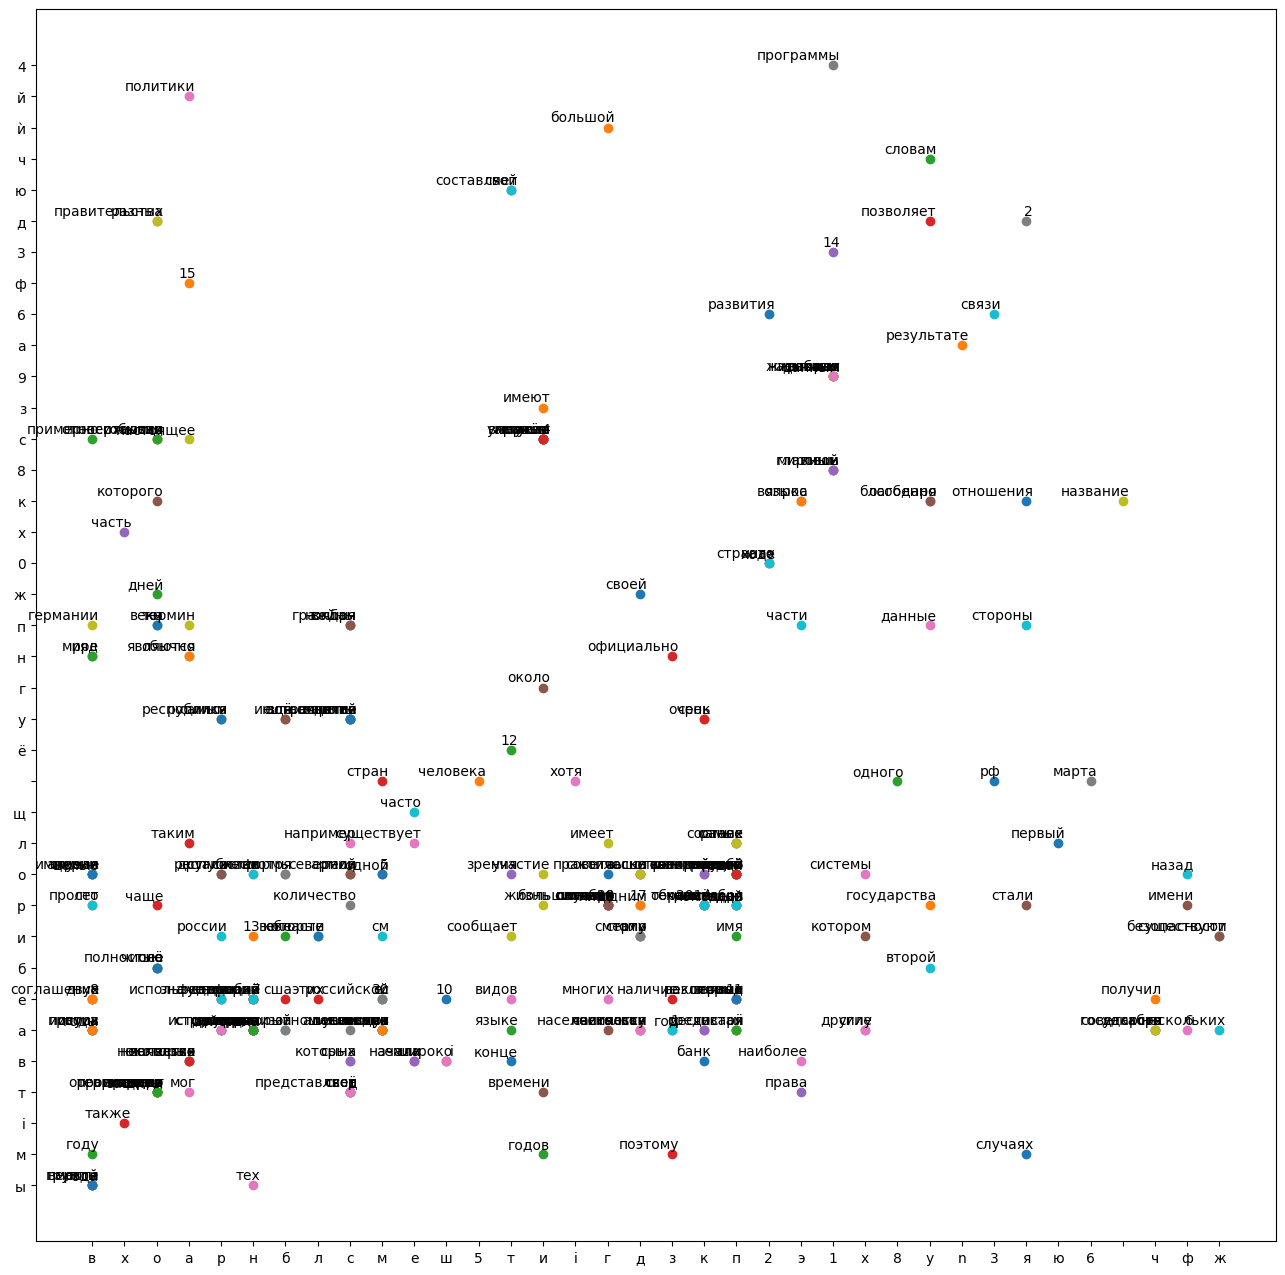

In [83]:

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                    xy=(x[i], y[i]),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
plt.show()

# BERT Fine-Tune

In [1]:
import logging
from pathlib import Path
from typing import List, Mapping, Tuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import yaml
from catalyst.utils import set_global_seed, prepare_cudnn
from transformers import AutoTokenizer, AutoConfig, AutoModel
from catalyst.callbacks.metrics.accuracy import AccuracyCallback
from catalyst.dl import (
    CheckpointCallback,
    OptimizerCallback,
    SchedulerCallback,
    SupervisedRunner,
)

project_root: Path = Path("").parent.parent

/home/leysh/miniconda3/envs/catalyst1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 17
PATH_TO_LOG_FOLDER = Path('logdir')

## Data Load

In [3]:
class TextClassificationDataset(Dataset):
    """
    Wrapper around Torch Dataset to perform text classification
    """

    def __init__(
        self,
        texts: List[str],
        questions: List[str],
        labels: List[str] = None,
        label_dict: Mapping[str, int] = None,
        max_seq_length: int = None,
        model_name: str = None,
    ):
        """
        Args:
            texts (List[str]): a list with texts to classify or to train the
                classifier on
            labels List[str]: a list with classification labels (optional)
            label_dict (dict): a dictionary mapping class names to class ids,
                to be passed to the validation data (optional)
            max_seq_length (int): maximal sequence length in tokens,
                texts will be stripped to this length
            model_name (str): transformer model name, needed to perform
                appropriate tokenization

        """

        self.texts = texts
        self.questions = questions
        self.labels = labels
        self.label_dict = label_dict
        self.max_seq_length = max_seq_length

        if self.label_dict is None and labels is not None:
            # {'class1': 0, 'class2': 1, 'class3': 2, ...}
            # using this instead of `sklearn.preprocessing.LabelEncoder`
            # no easily handle unknown target values
            self.label_dict = dict(zip(sorted(set(labels)), range(len(set(labels)))))

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        # suppresses tokenizer warnings
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.FATAL)

        # special tokens for transformers
        # in the simplest case a [CLS] token is added in the beginning
        # and [SEP] token is added in the end of a piece of text
        # [CLS] <indexes text tokens> [SEP] .. <[PAD]>
        self.sep_label = self.tokenizer.special_tokens_map['sep_token']
        self.sep_vid = self.tokenizer.vocab[self.sep_label]
        self.cls_label = self.tokenizer.special_tokens_map['cls_token']
        self.cls_vid = self.tokenizer.vocab[self.cls_label]
        self.pad_label = self.tokenizer.special_tokens_map['pad_token']
        self.pad_vid = self.tokenizer.vocab[self.pad_label]

    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return len(self.texts)

    def __getitem__(self, index) -> Mapping[str, torch.Tensor]:
        """Gets element of the dataset

        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """
        # encoding the text
        x = [self.texts[index], self.questions[index]]

        # a dictionary with `input_ids` and `attention_mask` as keys
        output_dict = self.tokenizer.encode_plus(
            text=x,
            ##text_pair=text_pair, 
            ##text_target=text_target, 
            ##text_pair_target=text_pair_target, 
            add_special_tokens=True,
            #  Pad to a maximum length specified with the argument max_length
            #  or to the maximum acceptable input length for the model if that argument is not provided.
            padding="max_length", 
            # Truncate to a maximum length specified with the argument max_length 
            # or to the maximum acceptable input length for the model if that argument is not provided. 
            # This will truncate token by token, 
            # removing a token from the longest sequence in the pair if a pair of sequences (or a batch of pairs) is provided.
            truncation=True,
            # Controls the maximum length to use by one of the truncation/padding parameters.
            max_length=self.max_seq_length, 
            # return pytorch tensor
            return_tensors="pt", 
            return_token_type_ids=True,
            return_attention_mask=True,
        )

        # for Catalyst, there needs to be a key called features
        output_dict["features"] = output_dict["input_ids"].squeeze(0)
        del output_dict["input_ids"]

        output_dict["token_type_ids"] = output_dict["token_type_ids"].squeeze(0)

        # encoding target
        if self.labels is not None:
            y = self.labels[index]
            y_encoded = torch.Tensor([self.label_dict.get(y, -1)]).long().squeeze(0)
            output_dict["targets"] = y_encoded
            
        return output_dict

In [4]:
def read_data(params: dict) -> Tuple[dict, dict]:
    """
    A custom function that reads data from CSV files, creates PyTorch datasets and
    data loaders. The output is provided to be easily used with Catalyst

    :param params: a dictionary read from the config.yml file
    :return: a tuple with 2 dictionaries
    """

    batch_size              = params["training"]["batch_size"]
    seed                    = SEED
    max_seq_length          = params["model"]["max_seq_length"]
    model_name_path_or_url  = params["model"]["model_name"]
    dataset_folder          = params["data"]["path_to_data"]
    context_column          = params["data"]["text_field_name"]
    question_column         = params["data"]["quest_field_name"]
    label_column            = params["data"]["label_field_name"]
    train_filename          = params["data"]["train_filename"]
    validation_filename     = params["data"]["validation_filename"]
    test_filename           = params["data"]["test_filename"]

    # reading CSV files to Pandas dataframes
    train_df = pd.read_json(Path(dataset_folder) / train_filename, lines=True)
    valid_df = pd.read_json(Path(dataset_folder) / validation_filename, lines=True)
    test_df  = pd.read_json(Path(dataset_folder) / test_filename, lines=True)

    # делаем маппинг из True/False в INT
    label_dict = dict()
    for i, v in enumerate(np.unique(valid_df[label_column].values)):
        label_dict[v] = i

    # creating PyTorch Datasets
    train_dataset = TextClassificationDataset(
        texts           = train_df[context_column].values.tolist(),
        questions       = train_df[question_column].values.tolist(),
        labels          = train_df[label_column].values,
        label_dict      = label_dict,
        max_seq_length  = max_seq_length,
        model_name      = model_name_path_or_url
    )

    valid_dataset = TextClassificationDataset(
        texts           = valid_df[context_column].values.tolist(),
        questions       = valid_df[question_column].values.tolist(),
        labels          = valid_df[label_column].values,
        label_dict      = label_dict,
        max_seq_length  = max_seq_length,
        model_name      = model_name_path_or_url
    )

    test_dataset = TextClassificationDataset(
        texts           = test_df[context_column].values.tolist(),
        questions       = test_df[question_column].values.tolist(),
        max_seq_length  = max_seq_length,
        model_name      = model_name_path_or_url,
    )

    set_global_seed(seed)

    # creating PyTorch data loaders and placing them in dictionaries (for Catalyst)
    train_val_loaders = {
        "train": DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True,
        ),
        "valid": DataLoader(
            dataset=valid_dataset,
            batch_size=batch_size,
            shuffle=False,
        ),
    }

    test_loaders = {
        "test": DataLoader(
            dataset=test_dataset,
            batch_size=batch_size,
            shuffle=False,
        )
    }

    del train_df, valid_df, test_df, train_dataset, valid_dataset, test_dataset
    del test_filename, validation_filename, train_filename, seed, model_name_path_or_url, max_seq_length, label_column, question_column, context_column, dataset_folder, batch_size
    return train_val_loaders, test_loaders

## Model

In [5]:
class BertForSequenceClassification(nn.Module):
    """
    Simplified version of the same class by HuggingFace.
    See transformers/modeling_distilbert.py in the transformers repository.
    """

    def __init__(
        self, 
        pretrained_model_name: str, 
        num_classes: int = None, 
        dropout: float = 0.3
    ):
        """
        Args:
            pretrained_model_name (str): HuggingFace model name.
                See transformers/modeling_auto.py
            num_classes (int): the number of class labels
                in the classification task
        """
        super().__init__()

        config = AutoConfig.from_pretrained(pretrained_model_name, num_labels=num_classes)

        self.model = AutoModel.from_pretrained(pretrained_model_name, config=config)
        self.dropout = nn.Dropout(dropout)

        if 1: #default out-of-box gateway
            self.classifier = nn.Linear(config.hidden_size, num_classes)
        else:
            self.classifier = nn.Linear(config.hidden_size * 2, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, **kwargs):
        attention_mask = kwargs['attention_mask']
        features = kwargs['features']
        token_type_ids = kwargs['token_type_ids']
        head_mask = None
    #def forward(self, features, attention_mask=None, token_type_ids=None, head_mask=None):
        """Compute class probabilities for the input sequence.

        Args:
            features (torch.Tensor): ids of each token,
                size ([bs, seq_length]
            attention_mask (torch.Tensor): binary tensor, used to select
                tokens which are used to compute attention scores
                in the self-attention heads, size [bs, seq_length]
            head_mask (torch.Tensor): 1.0 in head_mask indicates that
                we keep the head, size: [num_heads]
                or [num_hidden_layers x num_heads]
        Returns:
            PyTorch Tensor with predicted class scores
        """
        assert attention_mask is not None, "attention mask is none"

        # taking BERTModel output
        # see https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel
        bert_output = self.model(
            input_ids=features, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids, 
            head_mask=head_mask)
        # we only need the hidden state here and don't need
        # transformer output, so index 0

        if 1: #default out-of-box gateway
            seq_output = bert_output[0]  # (bs, seq_len, dim)
            # mean pooling, i.e. getting average representation of all tokens
            pooled_output = seq_output.mean(axis=1)  # (bs, dim)
            pooled_output = self.dropout(pooled_output)  # (bs, dim)
            scores = self.classifier(pooled_output)  # (bs, num_classes)
        else:
            encoder_out = bert_output['last_hidden_state']
            
            pooled_output, _ = torch.max(encoder_out, 1)
            pooled_output = torch.relu(pooled_output)
            
            pooled_output_mean = torch.mean(encoder_out, 1)
            #cls = bert_output[:, 0, :]
            pooled_output = torch.cat((pooled_output, pooled_output_mean), 1)
            
            pooled_output = self.dropout(pooled_output)
            scores = self.classifier(pooled_output)
            
            #scores = (logits,) + scores[2:]  # add hidden states and attention if they are here

            #if self.model labels is not None:
            #    if self.num_labels == 1:
            #        # We are doing regression
            #        loss_fct = MSELoss()
            #        loss = loss_fct(logits.view(-1), labels.view(-1))
            #    else:
            #        loss = torch.nn.functional.binary_cross_entropy_with_logits( logits.view(-1), labels.view(-1) )
            #    outputs = (loss,) + outputs
        scores = self.softmax(scores)
        return scores

## Train

Из-за того, что Cuda не умеет освобождать VRAM каждый раз приходится перезапускать ядро поэтому делать прогон серии конфигураций не имеет смысла

In [6]:
def getResultPath(config_key):
    return PATH_TO_LOG_FOLDER / config_key / "csv_logger" / "valid.csv"

In [7]:
def getConfigPaths(aL, aModels, aSeqSize):
    configs_dict = dict()
    for iL in aL:
        for iM in aModels:
            for iS in aSeqSize:
                name = f'L{iL}_M{iM}_S{iS}'
                path = str(project_root / "configs" / f"config_{name}.yml")
                if os.path.exists(path):
                    configs_dict[name] = path
    return configs_dict
configs_dict = getConfigPaths(range(0, 6), range(1, 3), [2**i for i in range(1, 10)])
list(configs_dict.keys())

['L0_M1_S64',
 'L0_M1_S128',
 'L0_M1_S256',
 'L0_M1_S512',
 'L1_M1_S64',
 'L1_M1_S128',
 'L1_M1_S256',
 'L1_M1_S512',
 'L2_M1_S64',
 'L2_M1_S128',
 'L2_M1_S256',
 'L2_M1_S512',
 'L3_M1_S64',
 'L3_M1_S128',
 'L3_M1_S256',
 'L3_M1_S512',
 'L4_M1_S64',
 'L4_M1_S128',
 'L4_M1_S256',
 'L4_M1_S512',
 'L5_M1_S64',
 'L5_M1_S128',
 'L5_M1_S256',
 'L5_M1_S512']

In [10]:
# открываем файл конфига и зачитываем параметры
config_key = 'L0_M1_S64'
for config in configs_dict:
    if not os.path.exists(getResultPath(config)):
        config_key = config

with open(configs_dict[config_key]) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

In [9]:
config_key

'L5_M1_S64'

In [11]:
# загружаем датасет
train_val_loaders, test_loaders = read_data(params)

In [12]:
# загружаем модель из параметров с задангным кол-вом классов
model = BertForSequenceClassification(
    pretrained_model_name=params["model"]["model_name"],
    num_classes=params["model"]["num_classes"],
)

In [13]:
if 1:
    param_optimizer = list(model.model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
    ]
else:
    optimizer_grouped_parameters = model.parameters()

# specify criterion for the multi-class classification task, optimizer and scheduler
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(optimizer_grouped_parameters, lr=float(params["training"]["learn_rate"]))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [14]:
# сбрасываем сид рандомайзеров
set_global_seed(SEED)
prepare_cudnn(deterministic=True)

In [15]:
# определяем тренера, который будет оперировать с forward методом, 
# input_key - ключи, которые будут преедаваться из тензора в forward
runner = SupervisedRunner(input_key=("features", "attention_mask", "token_type_ids"))

In [16]:
logdir_path = PATH_TO_LOG_FOLDER / config_key
metric_key = 'accuracy01' #'loss'
# запускаем обучение
runner.train(
    # модель
    model=model,
    # функция потерь
    criterion=criterion,
    # оптимизатор
    optimizer=optimizer,
    # расписание
    scheduler=scheduler,
    # словарь из тренировочного и тестового датасета
    loaders=train_val_loaders,
    # функции обратной связи
    callbacks=[
        AccuracyCallback(num_classes=int(params["model"]["num_classes"]), input_key="logits", target_key="targets"),
        OptimizerCallback(accumulation_steps=int(params["training"]["accum_steps"]), metric_key=metric_key),
        SchedulerCallback(loader_key="valid", metric_key=metric_key),
        CheckpointCallback(logdir=logdir_path, loader_key="valid", metric_key=metric_key, minimize=True),
    ],
    # путь до папки, в которую будут сохраняться результаты, 
    # промежуточные модели: лучшая и последняя
    logdir=logdir_path,
    # количество эпох
    num_epochs=int(params["training"]["num_epochs"]),
    # вывод логирующих сообщений
    verbose=True,
)

1/40 * Epoch (train): 100%|██████████| 110/110 [00:09<00:00, 11.84it/s, accuracy01=0.800, loss=0.479, lr=3.000e-05, momentum=0.900]


train (1/40) accuracy01: 0.6146369354257314 | accuracy01/std: 0.11815417360030442 | loss: 0.6542410317354709 | loss/mean: 0.6542410317354709 | loss/std: 0.08023278974994309 | lr: 3e-05 | momentum: 0.9


1/40 * Epoch (valid): 100%|██████████| 52/52 [00:01<00:00, 31.48it/s, accuracy01=0.400, loss=0.787, lr=3.000e-05, momentum=0.900]


valid (1/40) accuracy01: 0.5749086480265557 | accuracy01/std: 0.12256465759123214 | loss: 0.6785958600973533 | loss/mean: 0.6785958600973533 | loss/std: 0.08267849741729917 | lr: 3e-05 | momentum: 0.9
* Epoch (1/40) lr: 3e-05 | momentum: 0.9


2/40 * Epoch (train): 100%|██████████| 110/110 [00:08<00:00, 12.77it/s, accuracy01=0.600, loss=0.793, lr=3.000e-05, momentum=0.900]


train (2/40) accuracy01: 0.7272727273408855 | accuracy01/std: 0.10397310556680142 | loss: 0.5742048955836115 | loss/mean: 0.5742048955836115 | loss/std: 0.07017269186490252 | lr: 3e-05 | momentum: 0.9


2/40 * Epoch (valid): 100%|██████████| 52/52 [00:01<00:00, 33.89it/s, accuracy01=0.600, loss=0.779, lr=3.000e-05, momentum=0.900]


valid (2/40) accuracy01: 0.5809987821184037 | accuracy01/std: 0.1414799003362712 | loss: 0.7125624590320797 | loss/mean: 0.7125624590320797 | loss/std: 0.12615955637850554 | lr: 3e-05 | momentum: 0.9
* Epoch (2/40) lr: 3e-05 | momentum: 0.9


3/40 * Epoch (train): 100%|██████████| 110/110 [00:08<00:00, 12.83it/s, accuracy01=0.800, loss=0.518, lr=3.000e-05, momentum=0.900]


train (3/40) accuracy01: 0.7861635220466578 | accuracy01/std: 0.10298090632592112 | loss: 0.5146035968132741 | loss/mean: 0.5146035968132741 | loss/std: 0.08473406066959667 | lr: 3e-05 | momentum: 0.9


3/40 * Epoch (valid): 100%|██████████| 52/52 [00:01<00:00, 34.88it/s, accuracy01=0.400, loss=0.885, lr=3.000e-05, momentum=0.900]


valid (3/40) accuracy01: 0.605359317941294 | accuracy01/std: 0.14130885990976344 | loss: 0.690208667306168 | loss/mean: 0.690208667306168 | loss/std: 0.12408323821500312 | lr: 3e-05 | momentum: 0.9
* Epoch (3/40) lr: 3e-05 | momentum: 0.9


4/40 * Epoch (train):   7%|▋         | 8/110 [00:00<00:08, 12.42it/s, accuracy01=0.812, loss=0.468, lr=3.000e-05, momentum=0.900]

## Просмотр результатов

In [ ]:
def plotScores(d = [dict], column = [str]):
    for c in d:
        d[c] = d[c][column].to_numpy().astype(np.float32)

    # определяем размер полотна
    plt.figure(figsize=(12, 6)) 

    maxKey, minKey = None, None
    maxVal, minVal = None, None
    for key in d:
        curMax, curMin = np.max(d[key]), np.min(d[key])
        if maxKey == None or curMax > maxVal:
            maxKey, maxVal = key, curMax
        if minKey == None or curMin < minVal:
            minKey, minVal = key, curMin

    # рисуем графики с маркерами
    for key in d:
        plt.plot(
            d[key], 
            linewidth=2 if key == maxKey else 1, # выделяем жирной линией наивысший график
            marker='o')

    # легенда в нижнем правом угле
    plt.legend(list(d.keys()), loc='lower right')

    # включаем сетку
    plt.grid(True)

    # задаем базовый шаг для Y
    step = 0.01 
    # округляем вниз и уменьшаем на шаг наименьшее значение
    minVal = np.floor(minVal / step) * step - step
    # округляем вверх и увеличиваем на шаг верхнее значение
    maxVal = np.ceil(maxVal / step) * step + step
    # вычисляем уменьшение шага чтоб не было накладывания лейблов,
    # "+2" это верхний и нижний шаг, 
    # "/20" - эмпирически выведено, что в полотно (12, 6) влезает 20 лейблов
    stepMul = np.ceil((int((maxVal - minVal) / step) + 2) / 20)
    # фиксируем диапозон Y 
    plt.yticks(np.arange(minVal, maxVal, step * stepMul))
    plt.ylim(minVal, maxVal)

    # фиксируем диапозон X 
    xticksLen = len(d[maxKey])
    plt.xticks(np.arange(0, xticksLen))
    plt.xlim(-1, xticksLen)

In [ ]:
def getResultsDF(aL, aModels, aSeqSize):
    df_dict = dict() 
    for c in getConfigPaths(aL, aModels, aSeqSize):
        try:
            df_dict[c] = pd.read_csv(logdir_path / c / "csv_logger" / "valid.csv")
        except:
            pass
    return df_dict

### Модель 'DeepPavlov/rubert-base-cased-sentence', Максимальная длина кодировки = 512

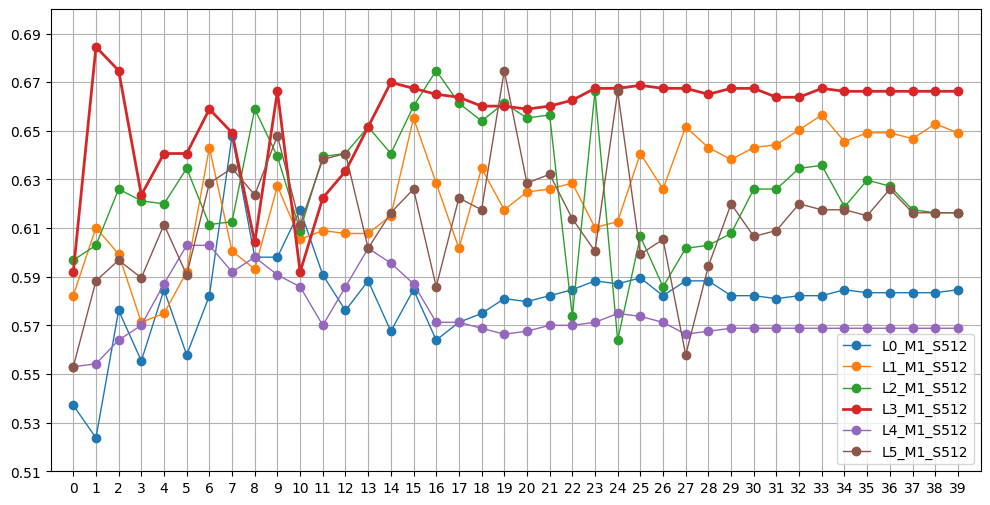

In [25]:
plotScores(getResultsDF(range(0, 6), [1], [512]), 'accuracy01')

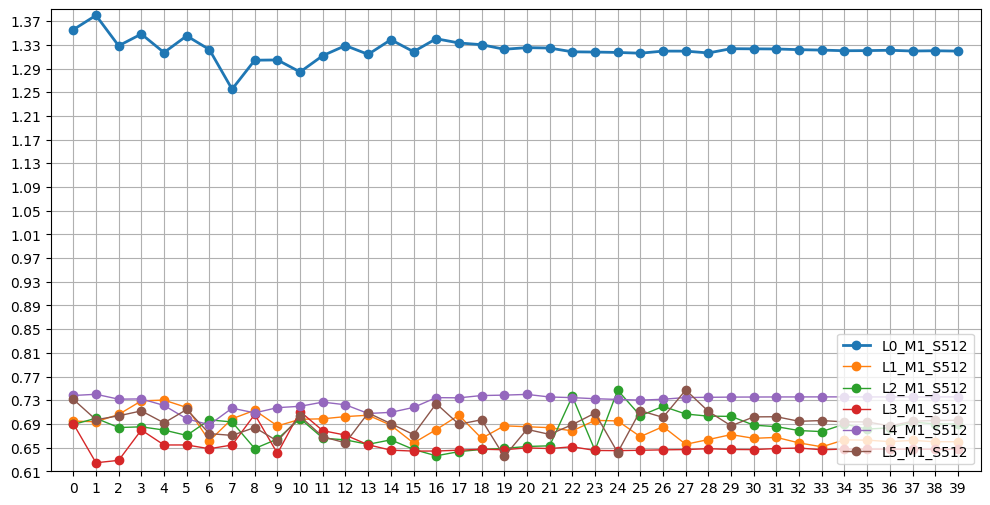

In [24]:
plotScores(getResultsDF(range(0, 6), [1], [512]), 'loss')

### Модель 'DeepPavlov/rubert-base-cased-sentence', Максимальная длина кодировки = 256

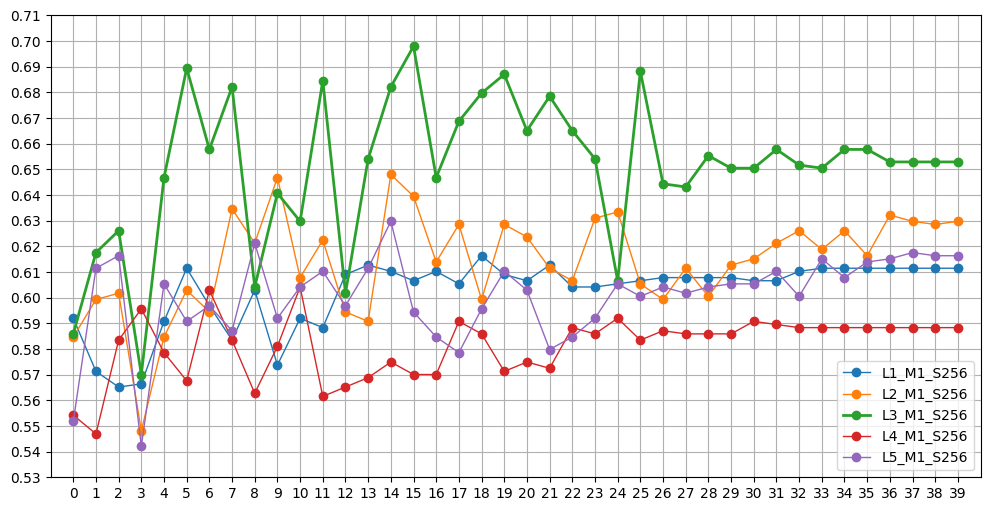

In [26]:
plotScores(getResultsDF(range(0, 6), [1], [256]), 'accuracy01')

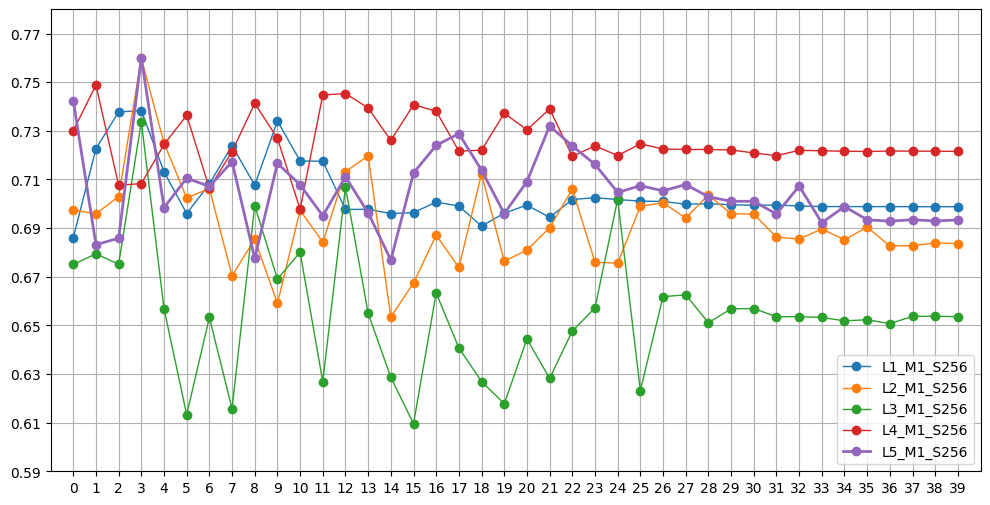

In [27]:
plotScores(getResultsDF(range(0, 6), [1], [256]), 'loss')

### Модель 'DeepPavlov/rubert-base-cased-sentence', Максимальная длина кодировки = 128

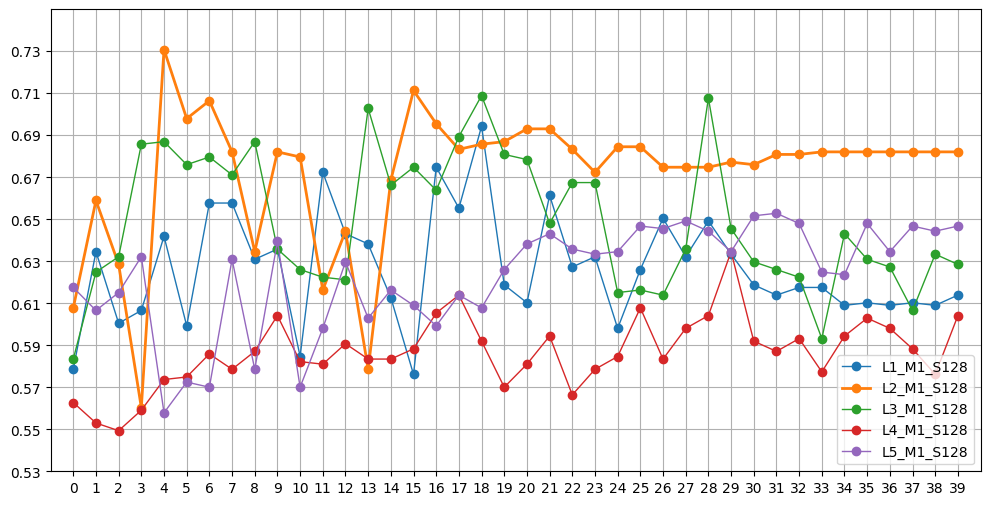

In [19]:
plotScores(getResultsDF(range(0, 6), [1], [128]), 'accuracy01')

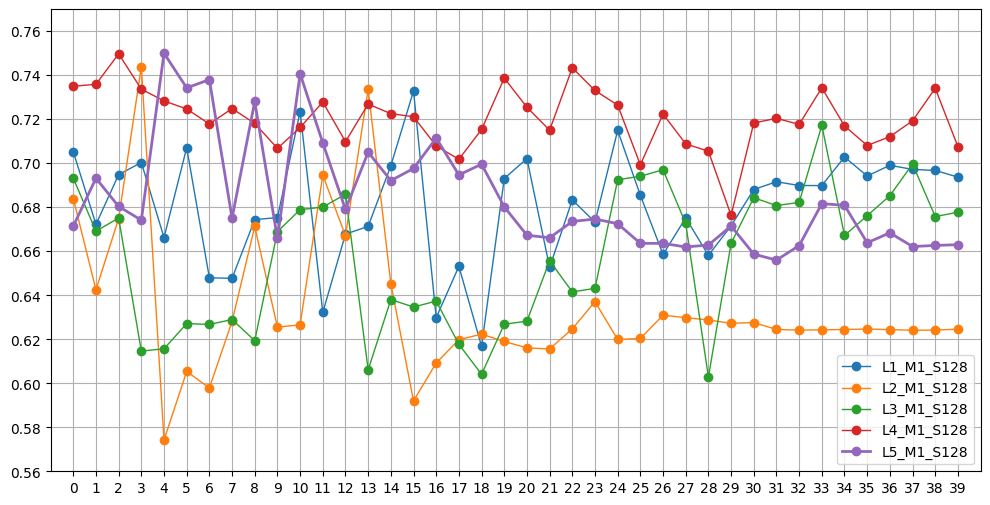

In [20]:
plotScores(getResultsDF(range(0, 6), [1], [128]), 'loss')

### Модель 'DeepPavlov/rubert-base-cased-sentence', Максимальная длина кодировки = 64

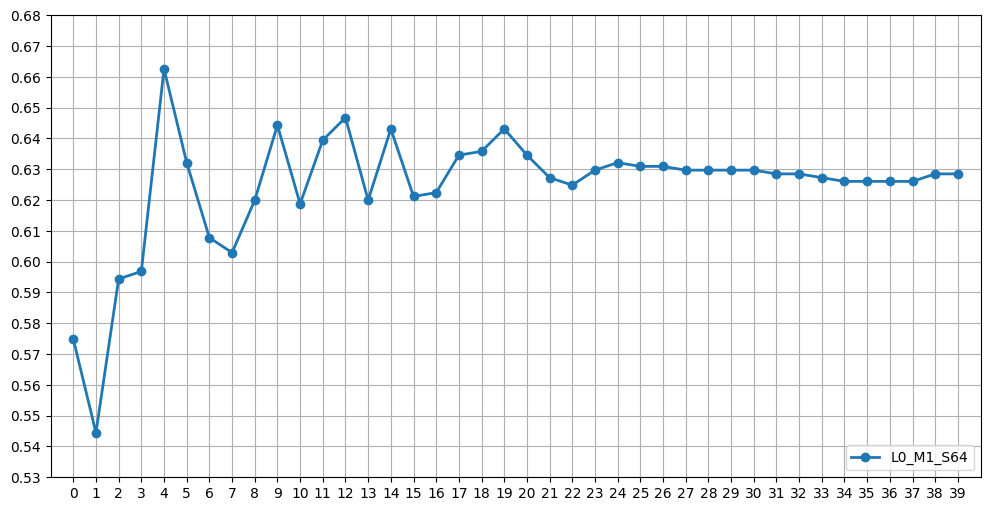

In [22]:
plotScores(getResultsDF(range(0, 6), [1], [64]), 'accuracy01')

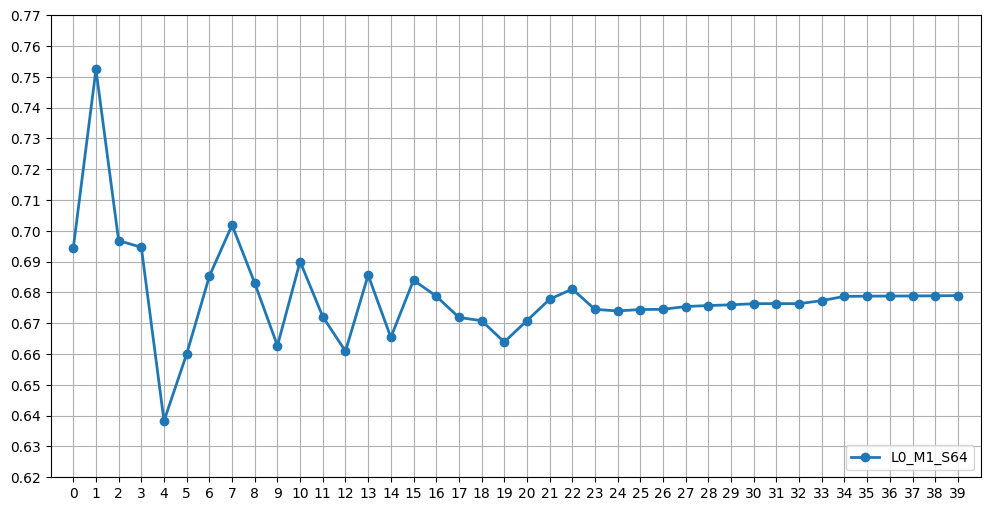

In [23]:
plotScores(getResultsDF(range(0, 6), [1], [64]), 'loss')

## Проверка результата 

In [ ]:
# and running inference
torch.cuda.empty_cache()

# getting validation metrics
metrics = runner.evaluate_loader(
    loader=train_val_loaders["valid"],
    callbacks=[AccuracyCallback(input_key="logits", target_key="targets")],
)
print(metrics)

# lastly, saving predicted scores for the test set
test_pred_scores = np.concatenate(
    [pred["logits"].detach().cpu().numpy() for pred in runner.predict_loader(loader=test_loaders["test"])]
)